In [1]:
cd lag-llama

D:\jupyter\lag-llama-git\lag-llama


In [2]:
#pip install -r requirements.txt

In [3]:
#!pip install pandas==2.0.3
#!pip install gluonts==0.14.4

In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir .

lag-llama.ckpt


In [5]:
from gluonts.torch import TemporalFusionTransformerEstimator, DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from sklearn.model_selection import train_test_split
from gluonts.dataset.pandas import PandasDataset
from tqdm.autonotebook import tqdm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from itertools import islice
import pandas as pd
import warnings
import torch

In [6]:
warnings.simplefilter("ignore", UserWarning)

In [7]:
dataset = pd.read_csv('../Top_Dataset/scraping/top_18_stock.csv', index_col=0, parse_dates=True)
dataset = dataset.iloc[:, [10]]

In [8]:
dataset

AMRT
2020-02-03   815
2020-02-04   810
2020-02-05   810
2020-02-06   805
2020-02-07   800
...          ...
2024-06-03  2800
2024-06-04  2790
2024-06-05  2720
2024-06-06  2780
2024-06-07  2760

[1135 rows x 1 columns]

In [9]:
len(dataset)

1135

In [10]:
#total_data = len(dataset )
#train      = int(0.7 * total_data)
#test       = total_data - train_data

#train_data = data.iloc[:train]
#test_data  = data.iloc[test:]

# Splitting data training (70%), testing data (30%).
train_data, test_data = train_test_split(dataset, test_size=0.3, shuffle=False)

print("Train data:", len(train_data))
print("Test data:", len(test_data))

Train data: 794
Test data: 341


In [11]:
freq_1 = pd.infer_freq(train_data.index)
freq_2 = pd.infer_freq(test_data.index)

print(f"frequency used train data: {freq_1}")
print(f"frequency used test data: {freq_2}")

frequency used train data: B
frequency used test data: B


In [12]:
prediction_length =32
num_samples=20
batch_size=64
epoch=50

# **Function**

In [13]:
def preprocess_dataset(data):
    for col in data.columns:
        if data[col].dtype != 'object' and not pd.api.types.is_string_dtype(data[col]):
            data[col] = data[col].astype('float32')
    return PandasDataset(dict(data))

backtrain_dataset = preprocess_dataset(train_data)
backtest_dataset  = preprocess_dataset(test_data)

### Function Lag-Llama Zero-Shot

In [14]:
def lag_llama_zero_shot(context_length, use_rope_scaling):
    
    ckpt = torch.load("lag-llama.ckpt", map_location="cuda")
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        batch_size=batch_size,
        num_parallel_samples=num_samples
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_zero_shot_it, ts_zero_shot_it = make_evaluation_predictions(
        dataset=backtest_dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    zero_shot_forecasts = list(forecast_zero_shot_it)
    zero_shot_tss = list(ts_zero_shot_it)

    evaluator = Evaluator()
    agg_metrics, ts_metrics = evaluator(iter(zero_shot_tss), iter(zero_shot_forecasts))

    return zero_shot_forecasts, zero_shot_tss, agg_metrics

In [15]:
def print_crps_zero_shot(context_length, use_rope_scaling, agg_metrics):
    crps = agg_metrics['mean_wQuantileLoss']
    print(f"Lag-Llama Zero-Shot ({context_length}) rope_scaled ({use_rope_scaling}) CRPS: {crps:.4f}")
    return crps

### Function Lag-Llama Fine-Tuning

In [16]:
def lag_llama_fine_tuning(context_length, lr):
    ckpt = torch.load("lag-llama.ckpt", map_location="cuda")
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        nonnegative_pred_samples=True,
        
        aug_prob=0,
        lr=lr,
        
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],
        
        batch_size=batch_size,
        num_parallel_samples=num_samples,
        trainer_kwargs={"max_epochs": epoch},
    )

    predictor = estimator.train(
        backtrain_dataset,
        cache_data=True,
        shuffle_buffer_length=1000
    )

    fine_tuning_forecast_it, fine_tuning_ts_it = make_evaluation_predictions(
        dataset=backtest_dataset,
        predictor=predictor,
        num_samples=num_samples
    )

    fine_tuning_forecasts = list(fine_tuning_forecast_it)
    fine_tuning_tss = list(fine_tuning_ts_it)

    evaluator = Evaluator()
    agg_metrics, ts_metrics = evaluator(iter(fine_tuning_tss), iter(fine_tuning_forecasts))

    return fine_tuning_forecasts, fine_tuning_tss, agg_metrics

In [17]:
def print_crps_fine_tuning(context_length, lr, agg_metrics):
    crps = agg_metrics['mean_wQuantileLoss']
    print(f"Lag-Llama Fine-Tuning ({context_length}) Lr {lr} CRPS: {crps:.4f}")
    return crps

### Function Plotting

In [18]:
def plotting(forecasts, tss):
    plt.figure(figsize=(20, 15))
    date_formatter = mdates.DateFormatter('%d-%m-%Y')
    plt.rcParams.update({'font.size': 15})

    for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
        ax = plt.subplot(3, 3, idx+1)
        plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target")
        forecast.plot(color='g')
        plt.xticks(rotation=60)
        ax.xaxis.set_major_formatter(date_formatter)
        ax.set_title(forecast.item_id)

    plt.gcf().tight_layout()
    plt.legend()
    plt.show()

# **Lag-Llama Zero-Shot**

## Zero-Shot Forecasting: Tuning the context length

### Get predictions with the default context length ***(32)***

In [19]:
forecasts_zero_shot_len_32_false, tss_zero_shot_len_32_false, agg_metrics = lag_llama_zero_shot(32, False)
zero_shot_len_32_false = print_crps_zero_shot(32, False, agg_metrics)

Running evaluation: 1it [00:00, ?it/s]

Lag-Llama Zero-Shot (32) rope_scaled (False) CRPS: 0.0383


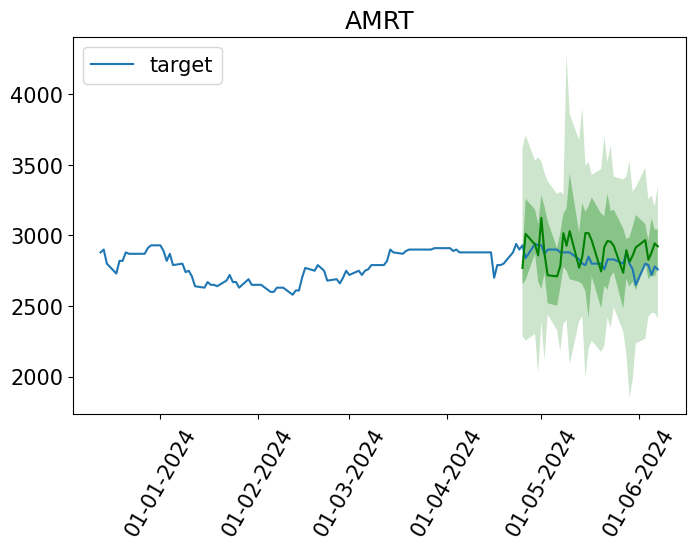

In [20]:
plotting(forecasts_zero_shot_len_32_false, tss_zero_shot_len_32_false)

### Get predictions with the default context length ***(64)***

In [21]:
forecasts_zero_shot_len_64_false, tss_zero_shot_len_64_false, agg_metrics = lag_llama_zero_shot(64, False)
zero_shot_len_64_false = print_crps_zero_shot(64, False, agg_metrics)

Running evaluation: 1it [00:00, ?it/s]

Lag-Llama Zero-Shot (64) rope_scaled (False) CRPS: 0.0415


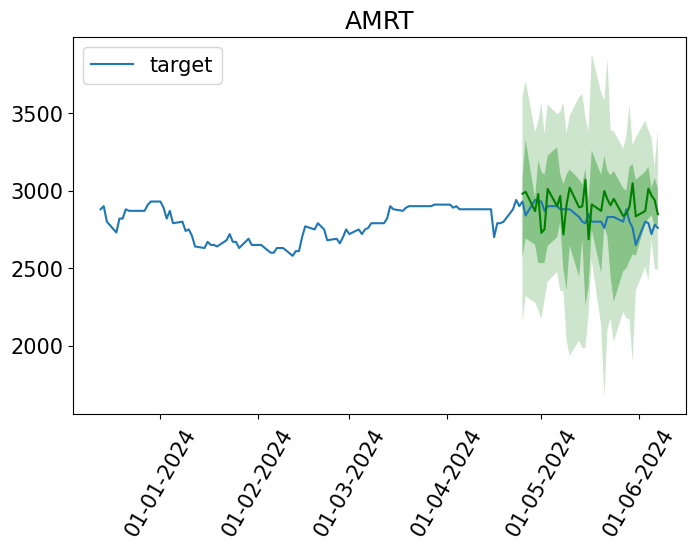

In [22]:
plotting(forecasts_zero_shot_len_64_false, tss_zero_shot_len_64_false)

Now enable **RoPE scaling** which better equips the model in handling large context lengths (larger than 32 in this case). This is done by passing `use_rope_scaling=True` to the `get_lag_llama_predictions` function.

In [23]:
forecasts_zero_shot_len_64_true, tss_zero_shot_len_64_true, agg_metrics = lag_llama_zero_shot(64, True)
zero_shot_len_64_true = print_crps_zero_shot(64, True, agg_metrics)

Running evaluation: 1it [00:00, ?it/s]

Lag-Llama Zero-Shot (64) rope_scaled (True) CRPS: 0.0422


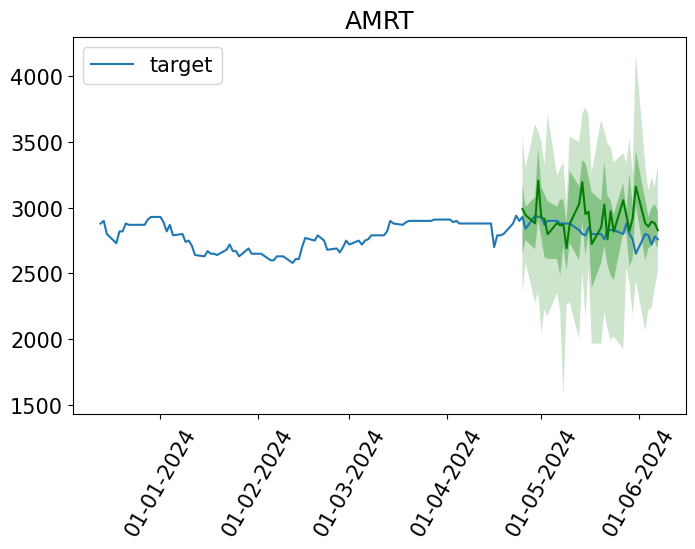

In [24]:
plotting(forecasts_zero_shot_len_64_true, tss_zero_shot_len_64_true)

### Get predictions with the default context length ***(128)***

In [25]:
forecasts_zero_shot_len_128_true, tss_zero_shot_len_128_true, agg_metrics = lag_llama_zero_shot(128, True)
zero_shot_len_128_true = print_crps_zero_shot(128, True, agg_metrics)

Running evaluation: 1it [00:00, 64.00it/s]

Lag-Llama Zero-Shot (128) rope_scaled (True) CRPS: 0.0397


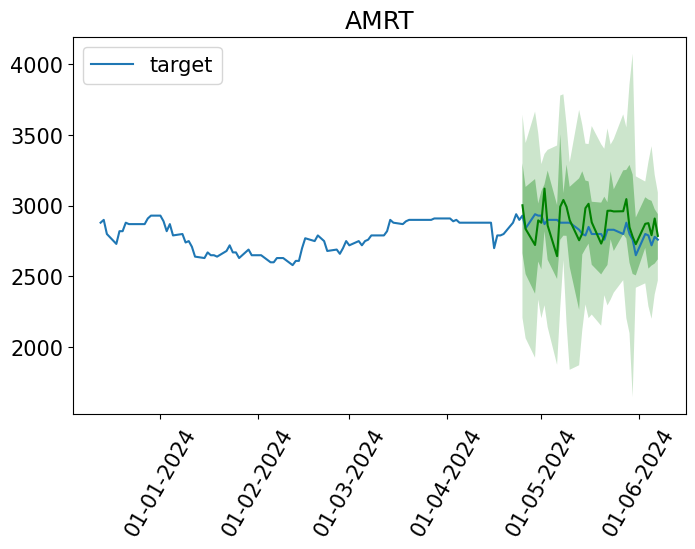

In [26]:
plotting(forecasts_zero_shot_len_128_true, tss_zero_shot_len_128_true)

### Get predictions with the default context length ***(256)***

In [27]:
forecasts_zero_shot_len_256_true, tss_zero_shot_len_256_true, agg_metrics = lag_llama_zero_shot(256, True)
zero_shot_len_256_true = print_crps_zero_shot(256, True, agg_metrics)

Running evaluation: 1it [00:00, 199.79it/s]

Lag-Llama Zero-Shot (256) rope_scaled (True) CRPS: 0.0394


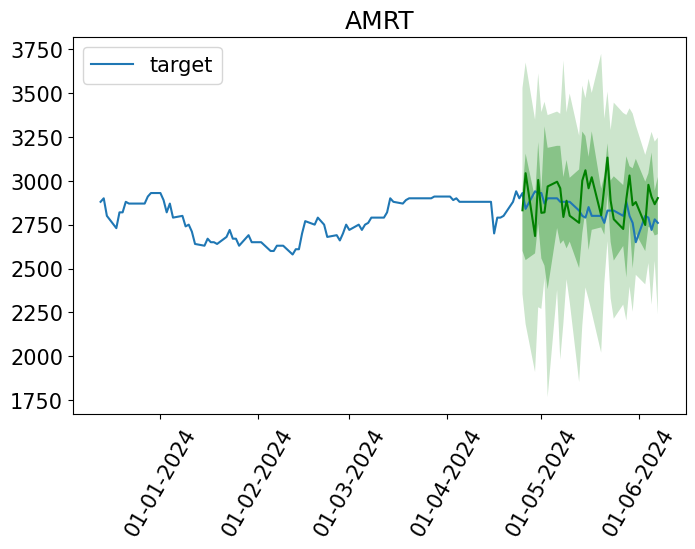

In [28]:
plotting(forecasts_zero_shot_len_256_true, tss_zero_shot_len_256_true)

### Get predictions with the default context length ***(512)***

In [29]:
forecasts_zero_shot_len_512_true, tss_zero_shot_len_512_true, agg_metrics = lag_llama_zero_shot(512, True)
zero_shot_len_512_true = print_crps_zero_shot(512, True, agg_metrics)

Running evaluation: 1it [00:00, 249.79it/s]

Lag-Llama Zero-Shot (512) rope_scaled (True) CRPS: 0.0384


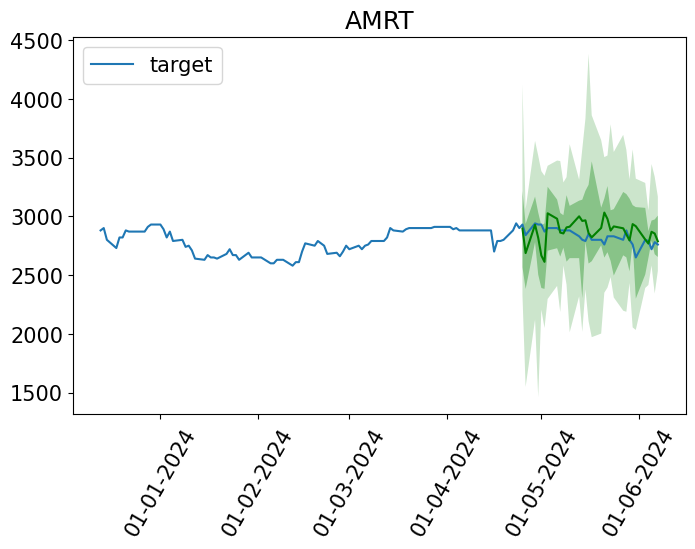

In [30]:
plotting(forecasts_zero_shot_len_512_true, tss_zero_shot_len_512_true)

### Get predictions with the default context length ***(1024)***

In [31]:
forecasts_zero_shot_len_1024_true, tss_zero_shot_len_1024_true, agg_metrics = lag_llama_zero_shot(1024, True)
zero_shot_len_1024_true = print_crps_zero_shot(1024, True, agg_metrics)

Running evaluation: 1it [00:00, ?it/s]

Lag-Llama Zero-Shot (1024) rope_scaled (True) CRPS: 0.0435


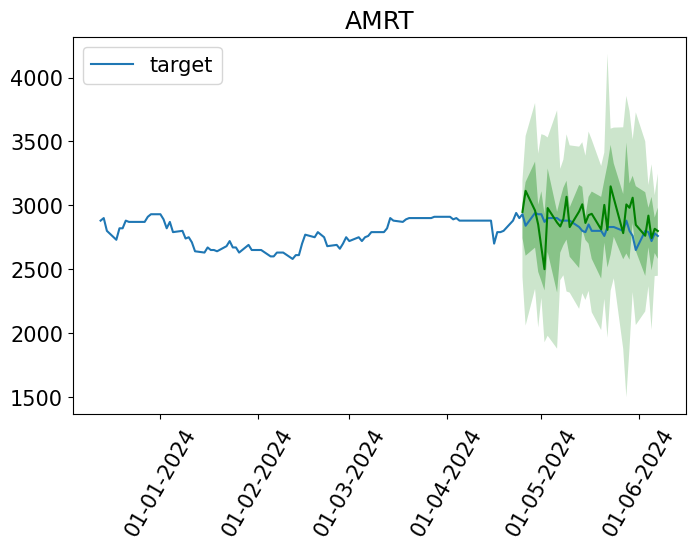

In [32]:
plotting(forecasts_zero_shot_len_1024_true, tss_zero_shot_len_1024_true)

# **Lag-Llama Fine-Tuning**

### ***Learning Rate 1e-2***

### Get predictions with the default context length ***(32)***

In [33]:
forecasts_fine_tuning_len_32_lr_1e_2, tss_fine_tuning_len_32_lr_1e_2, agg_metrics = lag_llama_fine_tuning(32, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.08889 (best 8.08889), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_497\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.56028 (best 7.56028), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_497\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.90748 (best 6.90748), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_497\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.88028 (best 6.88028), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_497\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.70014 (best 6.70014), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_497\\checkpoints\\epoch=4-step=250.ckpt' as top

In [34]:
fine_tuning_len_32_lr_1e_2 = print_crps_fine_tuning(32, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.01 CRPS: 0.0498


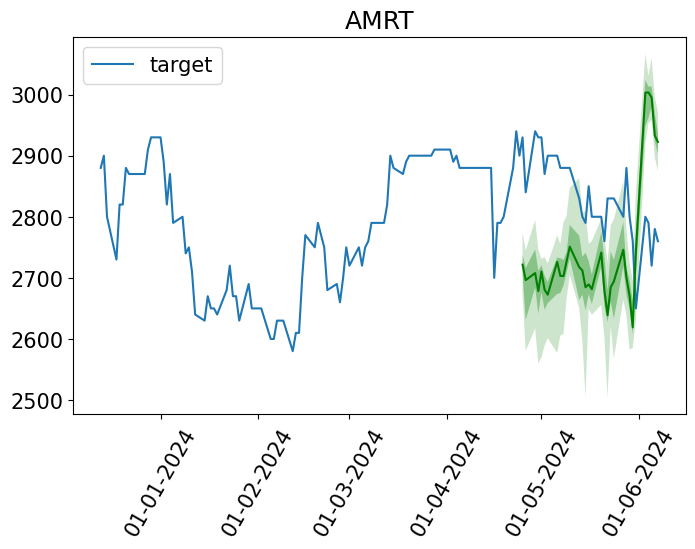

In [35]:
plotting(forecasts_fine_tuning_len_32_lr_1e_2, tss_fine_tuning_len_32_lr_1e_2)

### Get predictions with the default context length ***(64)***

In [36]:
forecasts_fine_tuning_len_64_lr_1e_2, tss_fine_tuning_len_64_lr_1e_2, agg_metrics = lag_llama_fine_tuning(64, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.97947 (best 7.97947), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_498\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.29127 (best 7.29127), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_498\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 6.95972 (best 6.95972), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_498\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 6.50533 (best 6.50533), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_498\\checkpoints\\epoch=6-step=350.ckpt' as top 1
Epoch 7, global step 400: 'tra

In [37]:
fine_tuning_len_64_lr_1e_2 = print_crps_fine_tuning(64, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.01 CRPS: 0.0295


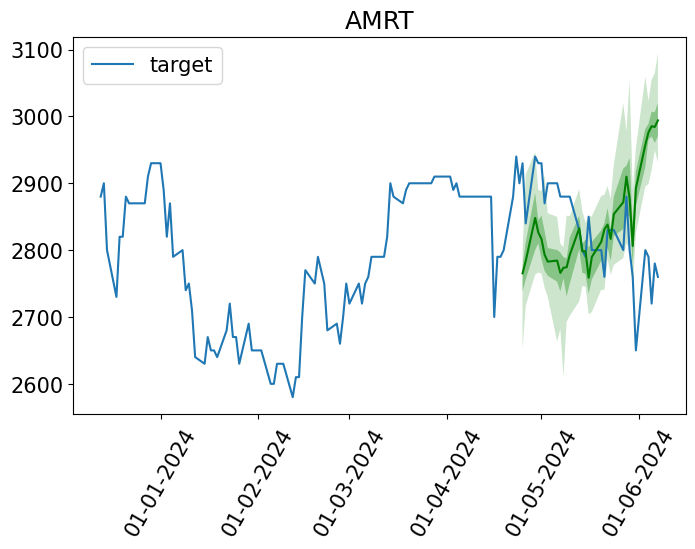

In [38]:
plotting(forecasts_fine_tuning_len_64_lr_1e_2, tss_fine_tuning_len_64_lr_1e_2)

### Get predictions with the default context length ***(128)***

In [39]:
forecasts_fine_tuning_len_128_lr_1e_2, tss_fine_tuning_len_128_lr_1e_2, agg_metrics = lag_llama_fine_tuning(128, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.17711 (best 8.17711), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_500\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.18314 (best 7.18314), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_500\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.95568 (best 6.95568), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_500\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.59922 (best 6.59922), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_500\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.36004 (best 6.36004), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [40]:
fine_tuning_len_128_lr_1e_2 = print_crps_fine_tuning(128, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.01 CRPS: 0.1072


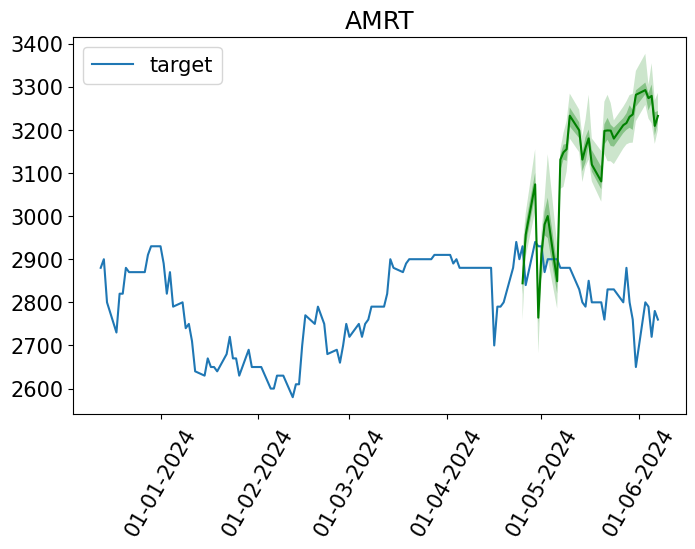

In [41]:
plotting(forecasts_fine_tuning_len_128_lr_1e_2, tss_fine_tuning_len_128_lr_1e_2)

### Get predictions with the default context length ***(256)***

In [42]:
forecasts_fine_tuning_len_256_lr_1e_2, tss_fine_tuning_len_256_lr_1e_2, agg_metrics = lag_llama_fine_tuning(256, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.21501 (best 8.21501), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_502\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.07495 (best 7.07495), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_502\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.05756 (best 7.05756), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_502\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.78064 (best 6.78064), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_502\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.36675 (best 6.36675), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [43]:
fine_tuning_len_256_lr_1e_2 = print_crps_fine_tuning(256, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.01 CRPS: 0.0491


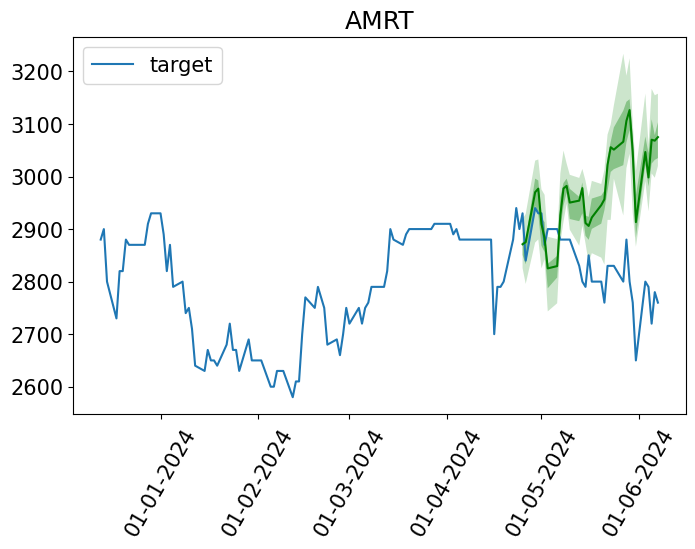

In [44]:
plotting(forecasts_fine_tuning_len_256_lr_1e_2, tss_fine_tuning_len_256_lr_1e_2)

### Get predictions with the default context length ***(512)***

In [45]:
forecasts_fine_tuning_len_512_lr_1e_2, tss_fine_tuning_len_512_lr_1e_2, agg_metrics = lag_llama_fine_tuning(512, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.94502 (best 7.94502), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_504\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.96002 (best 6.96002), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_504\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.76086 (best 6.76086), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_504\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.35545 (best 6.35545), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_504\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.30032 (best 6.30032), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_504\\checkpoints\\epoch=4-step=250.ckpt' as top

In [46]:
fine_tuning_len_512_lr_1e_2 = print_crps_fine_tuning(512, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.01 CRPS: 0.1349


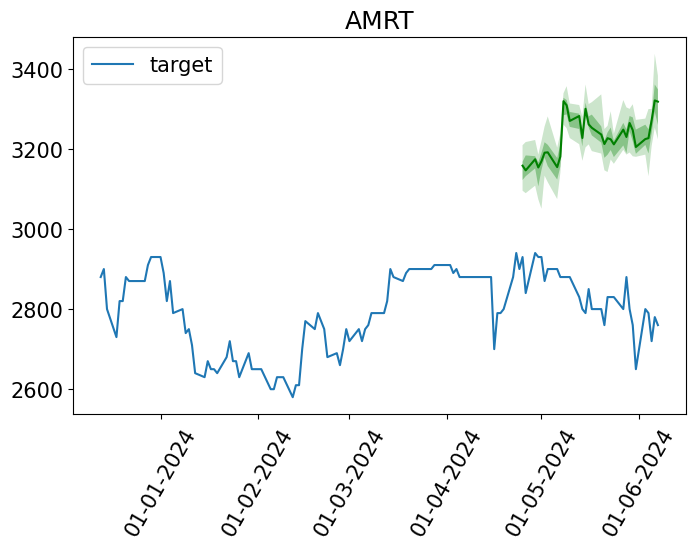

In [47]:
plotting(forecasts_fine_tuning_len_512_lr_1e_2, tss_fine_tuning_len_512_lr_1e_2)

### Get predictions with the default context length ***(1024)***

In [48]:
forecasts_fine_tuning_len_1024_lr_1e_2, tss_fine_tuning_len_1024_lr_1e_2, agg_metrics = lag_llama_fine_tuning(1024, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.83917 (best 7.83917), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_507\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.04262 (best 7.04262), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_507\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 6.83936 (best 6.83936), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_507\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.70507 (best 6.70507), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_507\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' was not in top 1
Epoch 7, global step 400: 'tra

In [49]:
fine_tuning_len_1024_lr_1e_2 = print_crps_fine_tuning(1024, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.01 CRPS: 0.0944


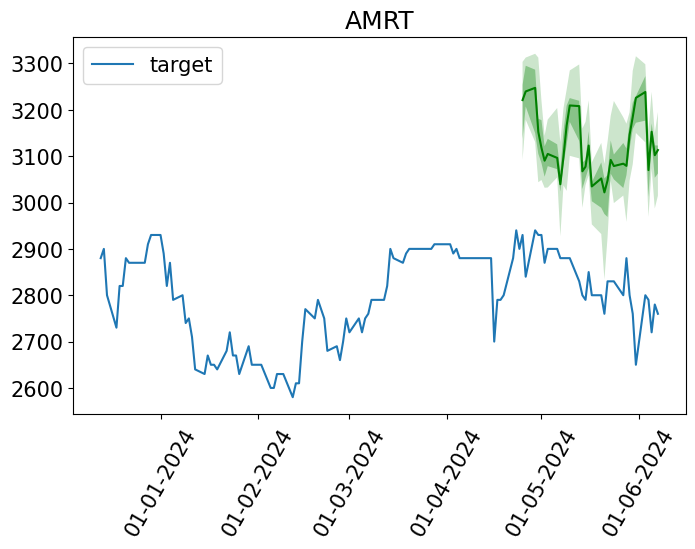

In [50]:
plotting(forecasts_fine_tuning_len_1024_lr_1e_2, tss_fine_tuning_len_1024_lr_1e_2)

### ***Learning Rate 1e-3***

### Get predictions with the default context length ***(32)***

In [51]:
forecasts_fine_tuning_len_32_lr_1e_3, tss_fine_tuning_len_32_lr_1e_3, agg_metrics = lag_llama_fine_tuning(32, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.54053 (best 8.54053), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_509\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.68837 (best 6.68837), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_509\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.09088 (best 6.09088), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_509\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.95403 (best 5.95403), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_509\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.91189 (best 5.91189), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_509\\checkpoints\\epoch=4-step=250.ckpt' as top

In [52]:
fine_tuning_len_32_lr_1e_3 = print_crps_fine_tuning(32, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.001 CRPS: 0.0984


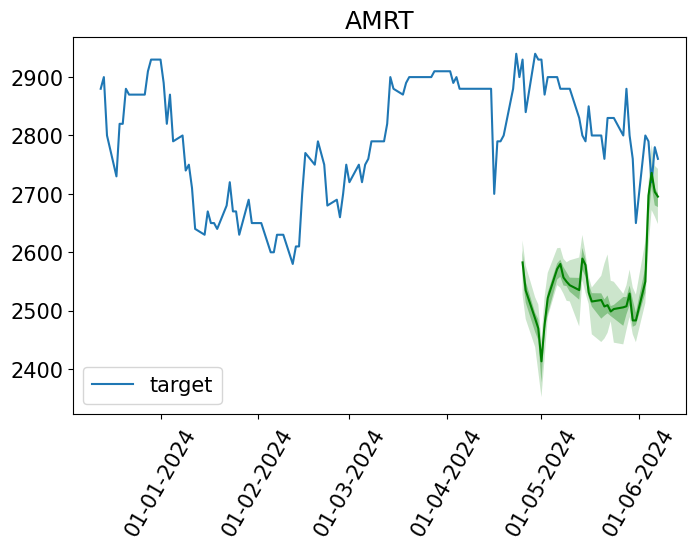

In [53]:
plotting(forecasts_fine_tuning_len_32_lr_1e_3, tss_fine_tuning_len_32_lr_1e_3)

### Get predictions with the default context length ***(64)***

In [54]:
forecasts_fine_tuning_len_64_lr_1e_3, tss_fine_tuning_len_64_lr_1e_3, agg_metrics = lag_llama_fine_tuning(64, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.48668 (best 8.48668), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_511\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.69833 (best 6.69833), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_511\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.60302 (best 6.60302), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_511\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.74065 (best 5.74065), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_511\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.60854 (best 5.60854), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_511\\checkpoints\\epoch=4-step=250.ckpt' as top

In [55]:
fine_tuning_len_64_lr_1e_3 = print_crps_fine_tuning(64, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.001 CRPS: 0.0349


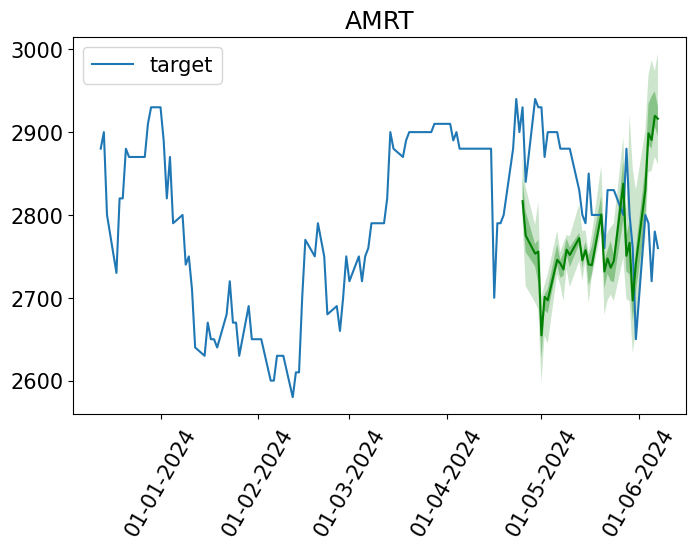

In [56]:
plotting(forecasts_fine_tuning_len_64_lr_1e_3, tss_fine_tuning_len_64_lr_1e_3)

### Get predictions with the default context length ***(128)***

In [57]:
forecasts_fine_tuning_len_128_lr_1e_3, tss_fine_tuning_len_128_lr_1e_3, agg_metrics = lag_llama_fine_tuning(128, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.80239 (best 7.80239), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_513\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.31406 (best 6.31406), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_513\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.68876 (best 5.68876), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_513\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.35105 (best 5.35105), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_513\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 5.24001 (best 5.24001), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [58]:
fine_tuning_len_128_lr_1e_3 = print_crps_fine_tuning(128, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.001 CRPS: 0.0538


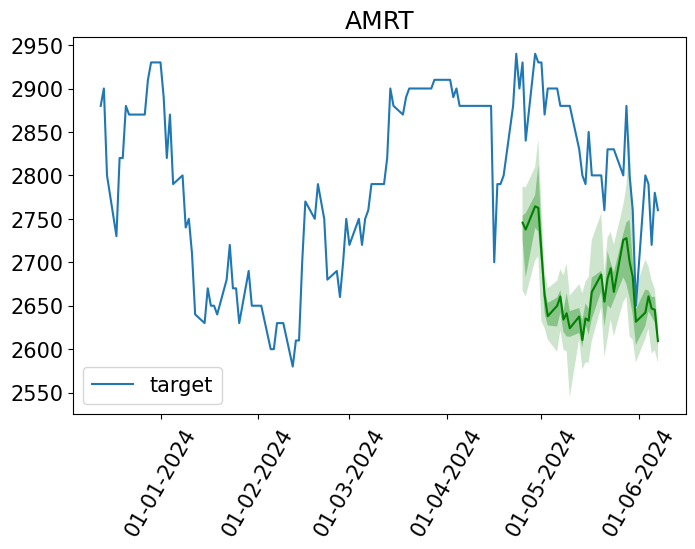

In [59]:
plotting(forecasts_fine_tuning_len_128_lr_1e_3, tss_fine_tuning_len_128_lr_1e_3)

### Get predictions with the default context length ***(256)***

In [60]:
forecasts_fine_tuning_len_256_lr_1e_3, tss_fine_tuning_len_256_lr_1e_3, agg_metrics = lag_llama_fine_tuning(256, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.36675 (best 7.36675), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_515\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.58516 (best 5.58516), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_515\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.55121 (best 5.55121), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_515\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.54083 (best 5.54083), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_515\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.15400 (best 5.15400), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_515\\checkpoints\\epoch=4-step=250.ckpt' as top

In [61]:
fine_tuning_len_256_lr_1e_3 = print_crps_fine_tuning(256, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.001 CRPS: 0.1336


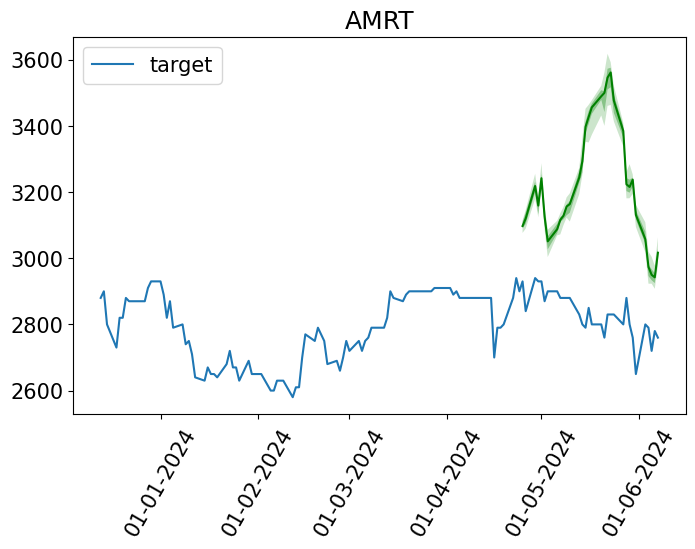

In [62]:
plotting(forecasts_fine_tuning_len_256_lr_1e_3, tss_fine_tuning_len_256_lr_1e_3)

### Get predictions with the default context length ***(512)***

In [63]:
forecasts_fine_tuning_len_512_lr_1e_3, tss_fine_tuning_len_512_lr_1e_3, agg_metrics = lag_llama_fine_tuning(512, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.70676 (best 8.70676), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_517\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.43052 (best 6.43052), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_517\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.60966 (best 5.60966), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_517\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.57509 (best 5.57509), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_517\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 5.12797 (best 5.12797), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [64]:
fine_tuning_len_512_lr_1e_3 = print_crps_fine_tuning(512, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.001 CRPS: 0.1458


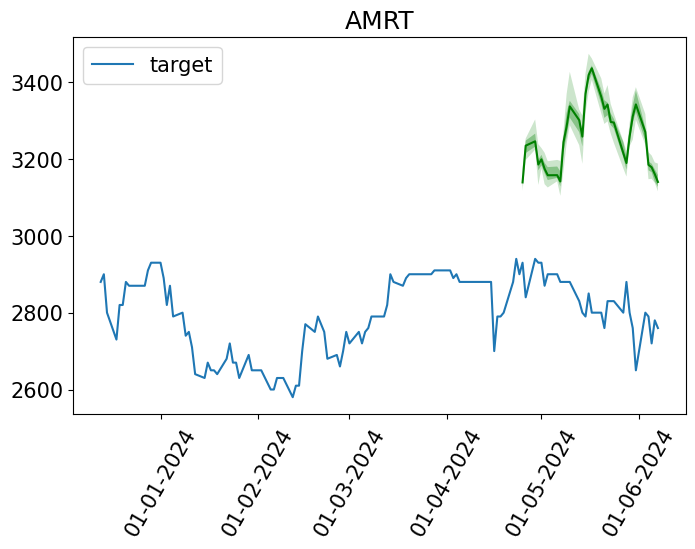

In [65]:
plotting(forecasts_fine_tuning_len_512_lr_1e_3, tss_fine_tuning_len_512_lr_1e_3)

### Get predictions with the default context length ***(1024)***

In [66]:
forecasts_fine_tuning_len_1024_lr_1e_3, tss_fine_tuning_len_1024_lr_1e_3, agg_metrics = lag_llama_fine_tuning(1024, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.36503 (best 7.36503), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_519\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.08114 (best 6.08114), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_519\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.53101 (best 5.53101), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_519\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.42073 (best 5.42073), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_519\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 5.16042 (best 5.16042), saving model to

In [67]:
fine_tuning_len_1024_lr_1e_3 = print_crps_fine_tuning(1024, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.001 CRPS: 0.1230


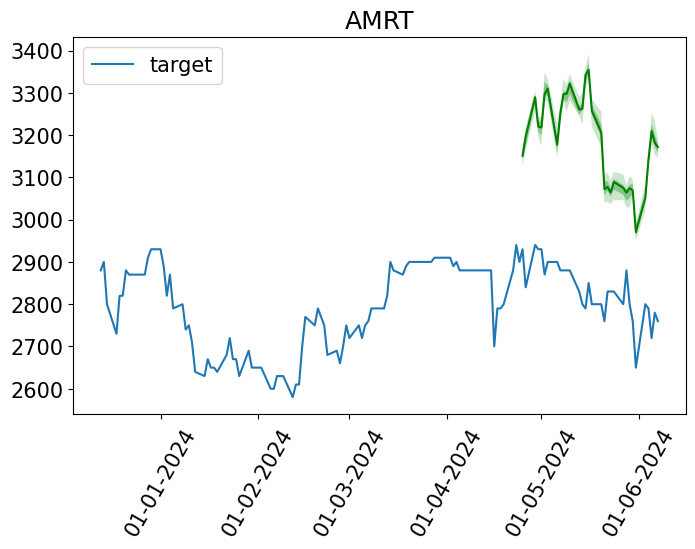

In [68]:
plotting(forecasts_fine_tuning_len_1024_lr_1e_3, tss_fine_tuning_len_1024_lr_1e_3)

### ***Learning Rate 1e-4***

### Get predictions with the default context length ***(32)***

In [69]:
forecasts_fine_tuning_len_32_lr_1e_4, tss_fine_tuning_len_32_lr_1e_4, agg_metrics = lag_llama_fine_tuning(32, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.89303 (best 5.89303), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_521\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.83847 (best 4.83847), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_521\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.73313 (best 4.73313), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_521\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 4.70229 (best 4.70229), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_521\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' was not in top 1
Epoch 7, global step 400: 'tra

In [70]:
fine_tuning_len_32_lr_1e_4 = print_crps_fine_tuning(32, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.0001 CRPS: 0.0642


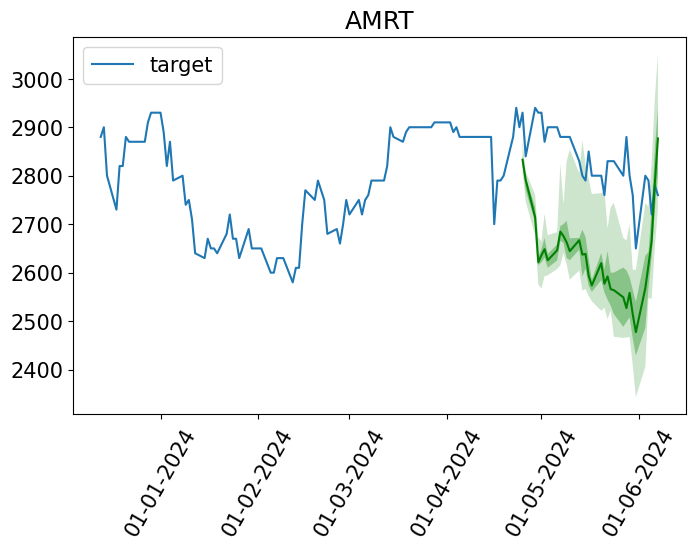

In [71]:
plotting(forecasts_fine_tuning_len_32_lr_1e_4, tss_fine_tuning_len_32_lr_1e_4)

### Get predictions with the default context length ***(64)***

In [72]:
forecasts_fine_tuning_len_64_lr_1e_4, tss_fine_tuning_len_64_lr_1e_4, agg_metrics = lag_llama_fine_tuning(64, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.70801 (best 5.70801), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_523\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.83734 (best 4.83734), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_523\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.73882 (best 4.73882), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_523\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.71233 (best 4.71233), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_523\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 4.64590 (best 4.64590), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [73]:
fine_tuning_len_64_lr_1e_4 = print_crps_fine_tuning(64, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.0001 CRPS: 0.0572


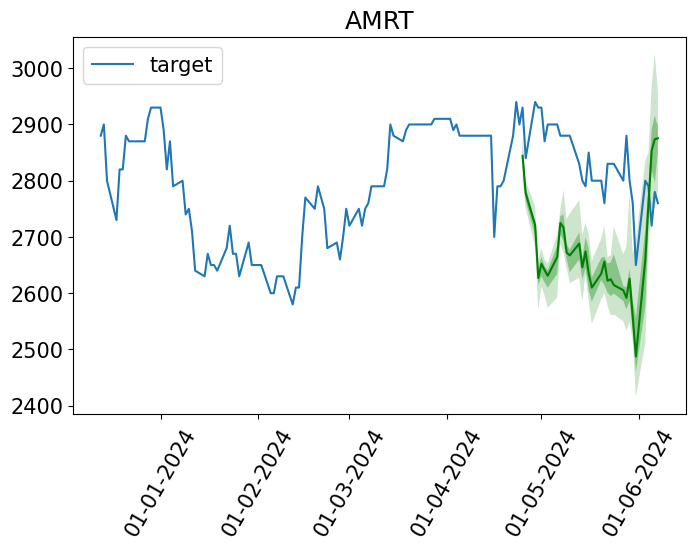

In [74]:
plotting(forecasts_fine_tuning_len_64_lr_1e_4, tss_fine_tuning_len_64_lr_1e_4)

### Get predictions with the default context length ***(128)***

In [75]:
forecasts_fine_tuning_len_128_lr_1e_4, tss_fine_tuning_len_128_lr_1e_4, agg_metrics = lag_llama_fine_tuning(128, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.46599 (best 5.46599), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_525\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.72169 (best 4.72169), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_525\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.72146 (best 4.72146), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_525\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.67232 (best 4.67232), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_525\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 4.64398 (best 4.64398), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [76]:
fine_tuning_len_128_lr_1e_4 = print_crps_fine_tuning(128, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.0001 CRPS: 0.0919


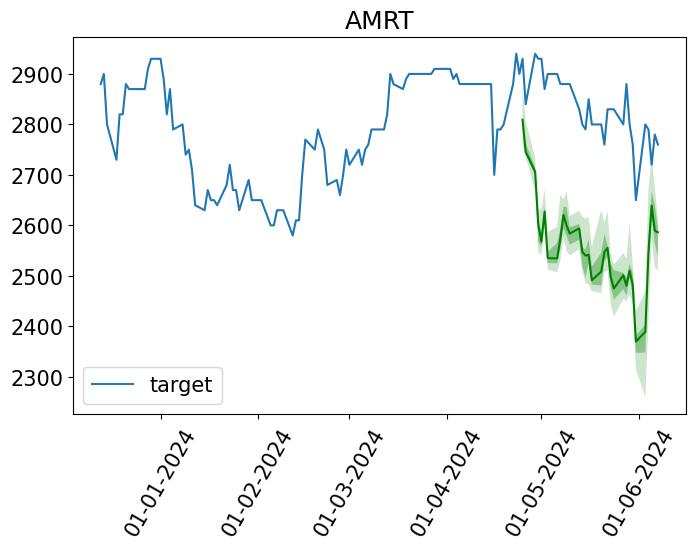

In [77]:
plotting(forecasts_fine_tuning_len_128_lr_1e_4, tss_fine_tuning_len_128_lr_1e_4)

### Get predictions with the default context length ***(256)***

In [78]:
forecasts_fine_tuning_len_256_lr_1e_4, tss_fine_tuning_len_256_lr_1e_4, agg_metrics = lag_llama_fine_tuning(256, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.46513 (best 5.46513), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_527\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.70966 (best 4.70966), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_527\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.65072 (best 4.65072), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_527\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 4.62685 (best 4.62685), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_527\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 4.56213 (best 4.56213), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [79]:
fine_tuning_len_256_lr_1e_4 = print_crps_fine_tuning(256, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.0001 CRPS: 0.0523


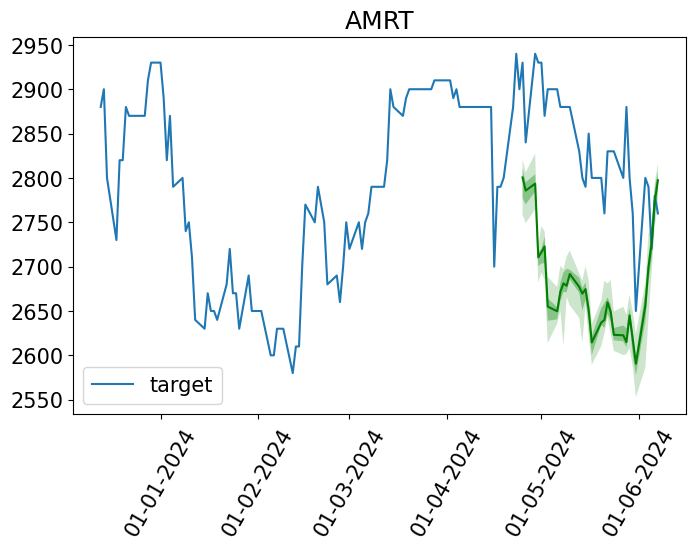

In [80]:
plotting(forecasts_fine_tuning_len_256_lr_1e_4, tss_fine_tuning_len_256_lr_1e_4)

### Get predictions with the default context length ***(512)***

In [81]:
forecasts_fine_tuning_len_512_lr_1e_4, tss_fine_tuning_len_512_lr_1e_4, agg_metrics = lag_llama_fine_tuning(512, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 4.98785 (best 4.98785), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_529\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.61215 (best 4.61215), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_529\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.53852 (best 4.53852), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_529\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.53383 (best 4.53383), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_529\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.46330 (best 4.46330), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_529\\checkpoints\\epoch=4-step=250.ckpt' as top

In [82]:
fine_tuning_len_512_lr_1e_4 = print_crps_fine_tuning(512, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.0001 CRPS: 0.0346


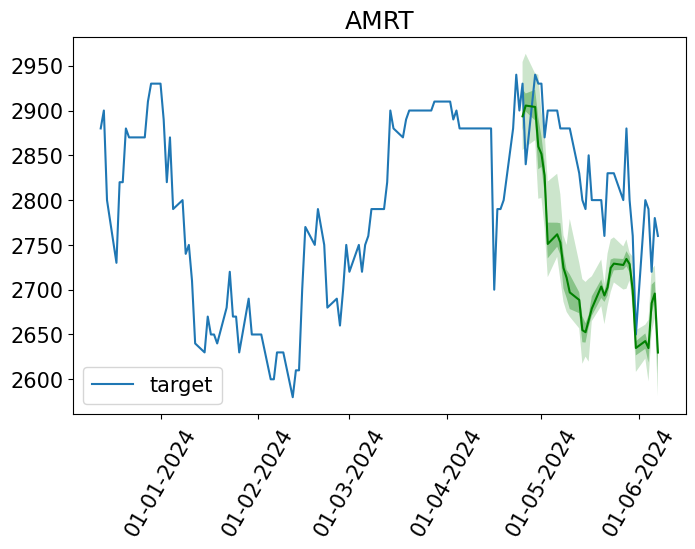

In [83]:
plotting(forecasts_fine_tuning_len_512_lr_1e_4, tss_fine_tuning_len_512_lr_1e_4)

### Get predictions with the default context length ***(1024)***

In [84]:
forecasts_fine_tuning_len_1024_lr_1e_4, tss_fine_tuning_len_1024_lr_1e_4, agg_metrics = lag_llama_fine_tuning(1024, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.05368 (best 5.05368), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_531\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.60418 (best 4.60418), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_531\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.53393 (best 4.53393), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_531\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.49733 (best 4.49733), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_531\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.49616 (best 4.49616), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_531\\checkpoints\\epoch=4-step=250.ckpt' as top

In [85]:
fine_tuning_len_1024_lr_1e_4 = print_crps_fine_tuning(1024, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.0001 CRPS: 0.0669


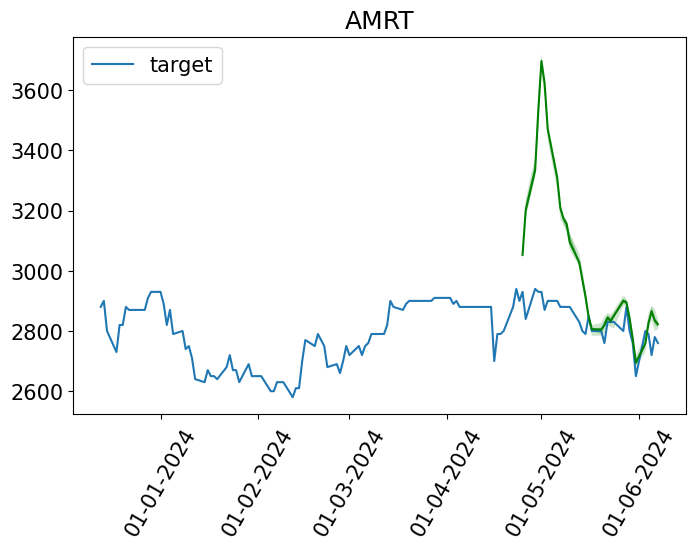

In [86]:
plotting(forecasts_fine_tuning_len_1024_lr_1e_4, tss_fine_tuning_len_1024_lr_1e_4)

### ***Learning Rate 5e-3***

### Get predictions with the default context length ***(32)***

In [87]:
forecasts_fine_tuning_len_32_lr_5e_3, tss_fine_tuning_len_32_lr_5e_3, agg_metrics = lag_llama_fine_tuning(32, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.04479 (best 8.04479), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_533\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.77982 (best 7.77982), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_533\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.68271 (best 7.68271), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_533\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.36692 (best 7.36692), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_533\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.33748 (best 7.33748), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_533\\checkpoints\\epoch=4-step=250.ckpt' as top

In [88]:
fine_tuning_len_32_lr_5e_3 = print_crps_fine_tuning(32, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.005 CRPS: 0.0782


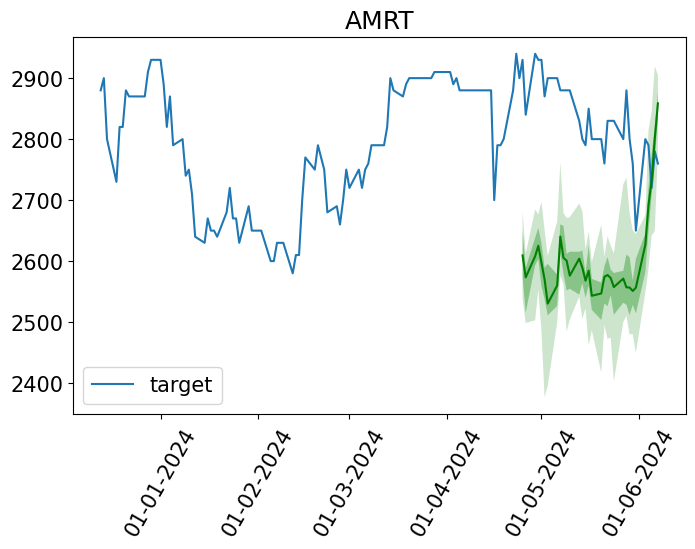

In [89]:
plotting(forecasts_fine_tuning_len_32_lr_5e_3, tss_fine_tuning_len_32_lr_5e_3)

### Get predictions with the default context length ***(64)***

In [90]:
forecasts_fine_tuning_len_64_lr_5e_3, tss_fine_tuning_len_64_lr_5e_3, agg_metrics = lag_llama_fine_tuning(64, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.15469 (best 8.15469), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_535\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.30818 (best 7.30818), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_535\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.91183 (best 6.91183), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_535\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.72637 (best 6.72637), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_535\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.15373 (best 6.15373), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_535\\checkpoints\\epoch=4-step=250.ckpt' as top

In [91]:
fine_tuning_len_64_lr_5e_3 = print_crps_fine_tuning(64, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.005 CRPS: 0.0222


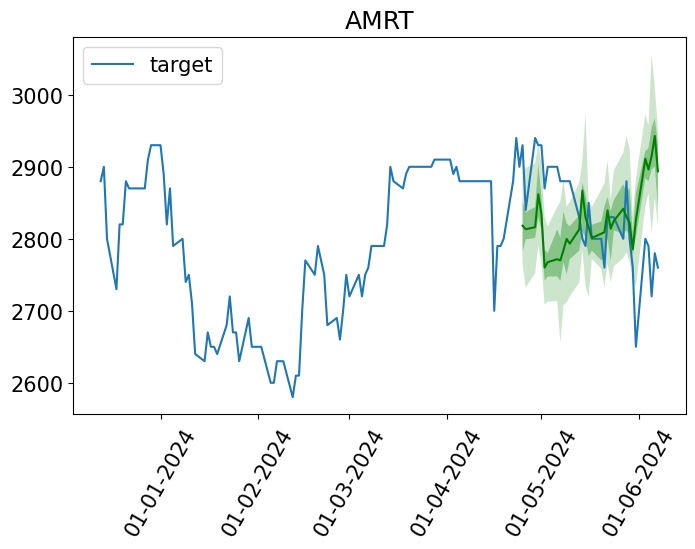

In [92]:
plotting(forecasts_fine_tuning_len_64_lr_5e_3, tss_fine_tuning_len_64_lr_5e_3)

### Get predictions with the default context length ***(128)***

In [93]:
forecasts_fine_tuning_len_128_lr_5e_3, tss_fine_tuning_len_128_lr_5e_3, agg_metrics = lag_llama_fine_tuning(128, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.14859 (best 8.14859), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_537\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.20211 (best 7.20211), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_537\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.09124 (best 7.09124), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_537\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 6.68236 (best 6.68236), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_537\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 6.25946 (best 6.25946), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [94]:
fine_tuning_len_128_lr_5e_3 = print_crps_fine_tuning(128, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.005 CRPS: 0.0236


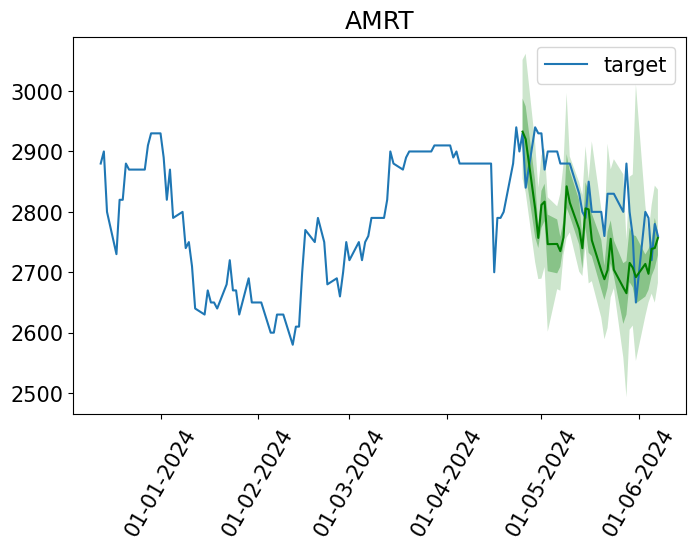

In [95]:
plotting(forecasts_fine_tuning_len_128_lr_5e_3, tss_fine_tuning_len_128_lr_5e_3)

### Get predictions with the default context length ***(256)***

In [96]:
forecasts_fine_tuning_len_256_lr_5e_3, tss_fine_tuning_len_256_lr_5e_3, agg_metrics = lag_llama_fine_tuning(256, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.58411 (best 8.58411), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_539\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.04340 (best 7.04340), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_539\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 6.55221 (best 6.55221), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_539\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.45095 (best 6.45095), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_539\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 6.07750 (best 6.07750), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [97]:
fine_tuning_len_256_lr_5e_3 = print_crps_fine_tuning(256, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.005 CRPS: 0.0615


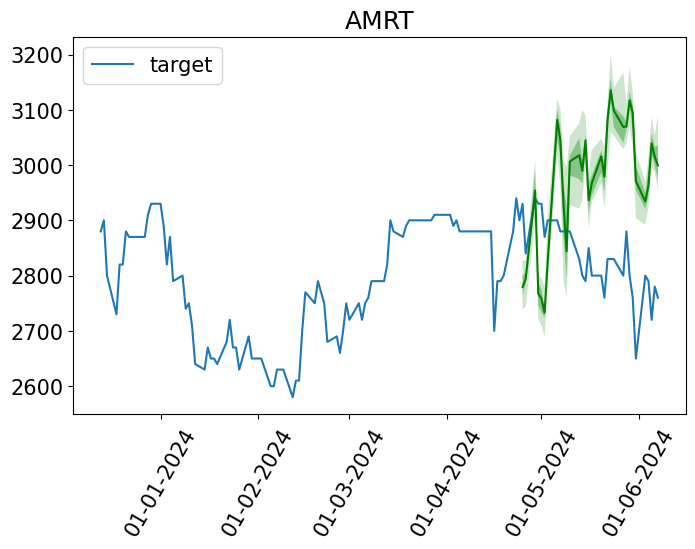

In [98]:
plotting(forecasts_fine_tuning_len_256_lr_5e_3, tss_fine_tuning_len_256_lr_5e_3)

### Get predictions with the default context length ***(512)***

In [99]:
forecasts_fine_tuning_len_512_lr_5e_3, tss_fine_tuning_len_512_lr_5e_3, agg_metrics = lag_llama_fine_tuning(512, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.77297 (best 7.77297), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_541\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.66358 (best 6.66358), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_541\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.20313 (best 6.20313), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_541\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.05438 (best 6.05438), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_541\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.75531 (best 5.75531), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_541\\checkpoints\\epoch=4-step=250.ckpt' as top

In [100]:
fine_tuning_len_512_lr_5e_3 = print_crps_fine_tuning(512, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.005 CRPS: 0.1135


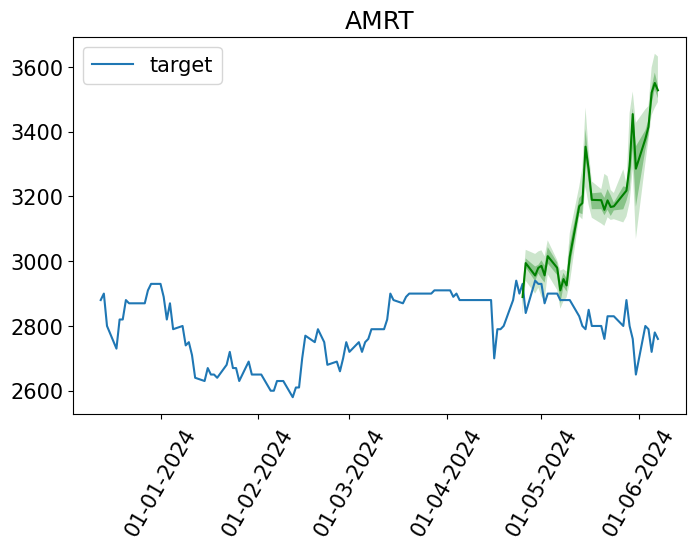

In [101]:
plotting(forecasts_fine_tuning_len_512_lr_5e_3, tss_fine_tuning_len_512_lr_5e_3)

### Get predictions with the default context length ***(1024)***

In [102]:
forecasts_fine_tuning_len_1024_lr_5e_3, tss_fine_tuning_len_1024_lr_5e_3, agg_metrics = lag_llama_fine_tuning(1024, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.66451 (best 7.66451), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_543\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.67955 (best 6.67955), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_543\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.46874 (best 6.46874), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_543\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.22425 (best 6.22425), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_543\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' was not in top 1
Epoch 7, global step 400: 'tra

In [103]:
fine_tuning_len_1024_lr_5e_3 = print_crps_fine_tuning(1024, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.005 CRPS: 0.1639


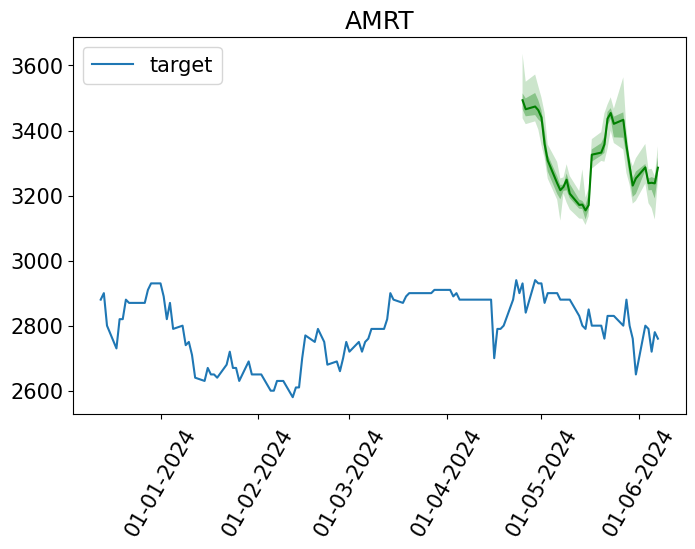

In [104]:
plotting(forecasts_fine_tuning_len_1024_lr_5e_3, tss_fine_tuning_len_1024_lr_5e_3)

### ***Learning Rate 5e-4***

### Get predictions with the default context length ***(32)***

In [105]:
forecasts_fine_tuning_len_32_lr_5e_4, tss_fine_tuning_len_32_lr_5e_4, agg_metrics = lag_llama_fine_tuning(32, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.43728 (best 7.43728), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_545\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.73392 (best 5.73392), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_545\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.29244 (best 5.29244), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_545\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.25631 (best 5.25631), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_545\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 5.10054 (best 5.10054), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [106]:
fine_tuning_len_32_lr_5e_4 = print_crps_fine_tuning(32, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.0005 CRPS: 0.0670


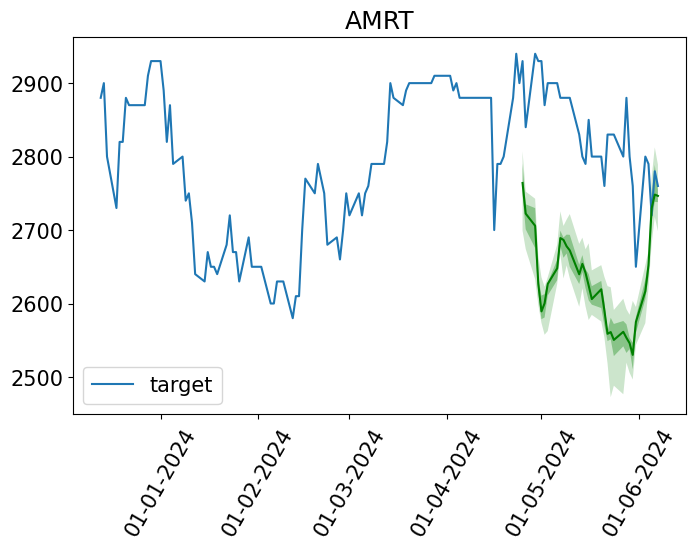

In [107]:
plotting(forecasts_fine_tuning_len_32_lr_5e_4, tss_fine_tuning_len_32_lr_5e_4)

### Get predictions with the default context length ***(64)***

In [108]:
forecasts_fine_tuning_len_64_lr_5e_4, tss_fine_tuning_len_64_lr_5e_4, agg_metrics = lag_llama_fine_tuning(64, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.61976 (best 7.61976), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_547\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.81382 (best 5.81382), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_547\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.35619 (best 5.35619), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_547\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.21094 (best 5.21094), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_547\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.00472 (best 5.00472), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [109]:
fine_tuning_len_64_lr_5e_4 = print_crps_fine_tuning(64, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.0005 CRPS: 0.0624


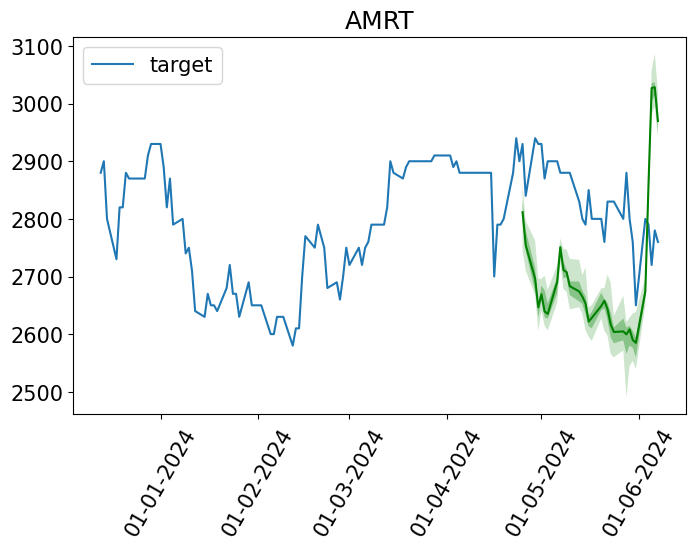

In [110]:
plotting(forecasts_fine_tuning_len_64_lr_5e_4, tss_fine_tuning_len_64_lr_5e_4)

### Get predictions with the default context length ***(128)***

In [111]:
forecasts_fine_tuning_len_128_lr_5e_4, tss_fine_tuning_len_128_lr_5e_4, agg_metrics = lag_llama_fine_tuning(128, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.09864 (best 7.09864), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_549\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.76893 (best 5.76893), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_549\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.30778 (best 5.30778), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_549\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.24470 (best 5.24470), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_549\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.00886 (best 5.00886), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_549\\checkpoints\\epoch=4-step=250.ckpt' as top

In [112]:
fine_tuning_len_128_lr_5e_4 = print_crps_fine_tuning(128, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.0005 CRPS: 0.0515


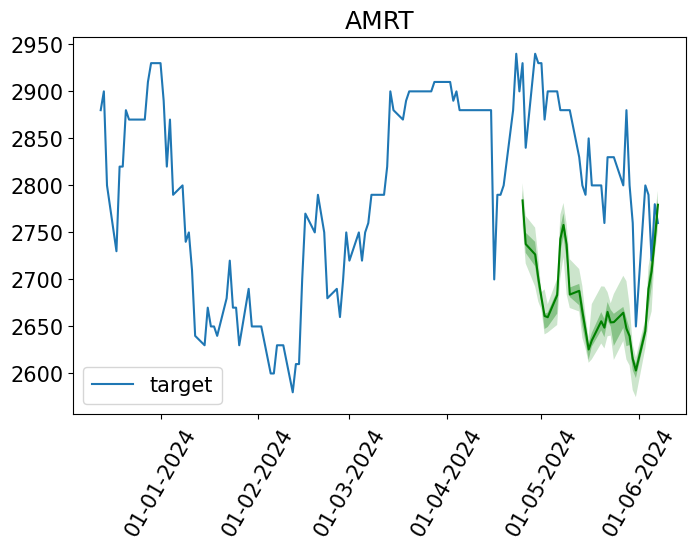

In [113]:
plotting(forecasts_fine_tuning_len_128_lr_5e_4, tss_fine_tuning_len_128_lr_5e_4)

### Get predictions with the default context length ***(256)***

In [114]:
forecasts_fine_tuning_len_256_lr_5e_4, tss_fine_tuning_len_256_lr_5e_4, agg_metrics = lag_llama_fine_tuning(256, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.38261 (best 7.38261), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_551\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.10430 (best 6.10430), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_551\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.36460 (best 5.36460), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_551\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.32066 (best 5.32066), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_551\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.00221 (best 5.00221), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_551\\checkpoints\\epoch=4-step=250.ckpt' as top

In [115]:
fine_tuning_len_256_lr_5e_4 = print_crps_fine_tuning(256, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.0005 CRPS: 0.0629


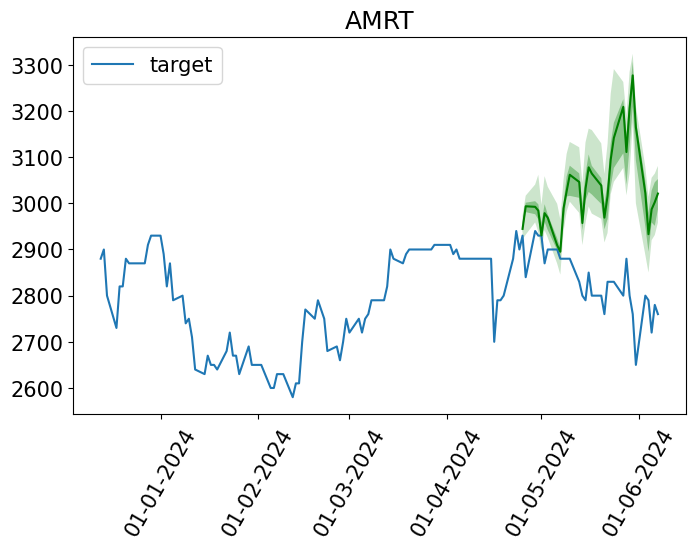

In [116]:
plotting(forecasts_fine_tuning_len_256_lr_5e_4, tss_fine_tuning_len_256_lr_5e_4)

### Get predictions with the default context length ***(512)***

In [117]:
forecasts_fine_tuning_len_512_lr_5e_4, tss_fine_tuning_len_512_lr_5e_4, agg_metrics = lag_llama_fine_tuning(512, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.68966 (best 6.68966), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_553\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.39499 (best 5.39499), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_553\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 5.01678 (best 5.01678), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_553\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.83078 (best 4.83078), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_553\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 4.78557 (best 4.78557), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [118]:
fine_tuning_len_512_lr_5e_4 = print_crps_fine_tuning(512, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.0005 CRPS: 0.1371


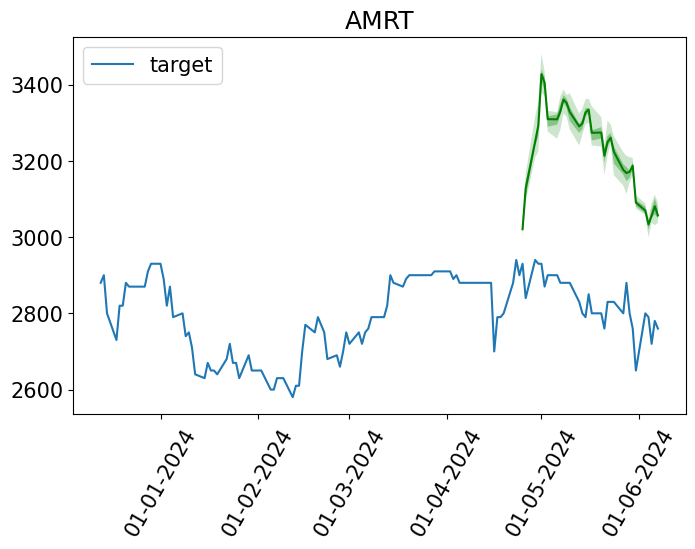

In [119]:
plotting(forecasts_fine_tuning_len_512_lr_5e_4, tss_fine_tuning_len_512_lr_5e_4)

### Get predictions with the default context length ***(1024)***

In [120]:
forecasts_fine_tuning_len_1024_lr_5e_4, tss_fine_tuning_len_1024_lr_5e_4, agg_metrics = lag_llama_fine_tuning(1024, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.37877 (best 6.37877), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_555\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.85136 (best 5.85136), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_555\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.33897 (best 5.33897), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_555\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.89439 (best 4.89439), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_555\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.81370 (best 4.81370), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_555\\checkpoints\\epoch=4-step=250.ckpt' as top

In [121]:
fine_tuning_len_1024_lr_5e_4 = print_crps_fine_tuning(1024, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.0005 CRPS: 0.0516


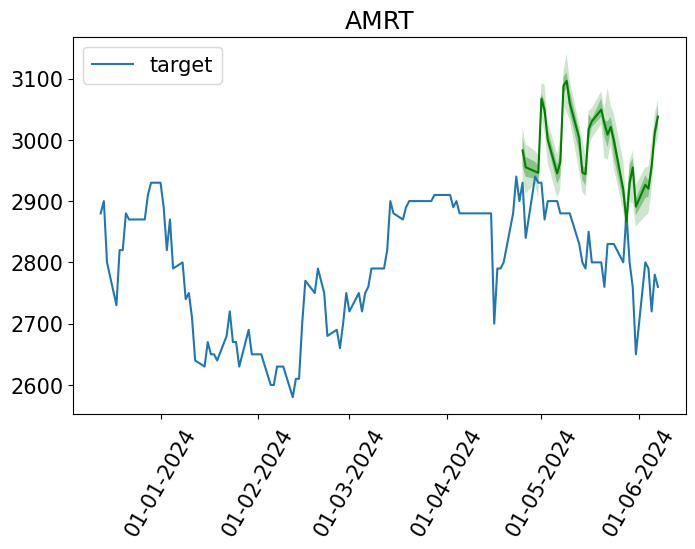

In [122]:
plotting(forecasts_fine_tuning_len_1024_lr_5e_4, tss_fine_tuning_len_1024_lr_5e_4)

### ***Learning Rate 5e-5***

### Get predictions with the default context length ***(32)***

In [123]:
forecasts_fine_tuning_len_32_lr_5e_5, tss_fine_tuning_len_32_lr_5e_5, agg_metrics = lag_llama_fine_tuning(32, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.04305 (best 5.04305), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_557\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.75485 (best 4.75485), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_557\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.67839 (best 4.67839), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_557\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.65560 (best 4.65560), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_557\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.63771 (best 4.63771), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_557\\checkpoints\\epoch=4-step=250.ckpt' as top

In [124]:
fine_tuning_len_32_lr_5e_5 = print_crps_fine_tuning(32, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 5e-05 CRPS: 0.0287


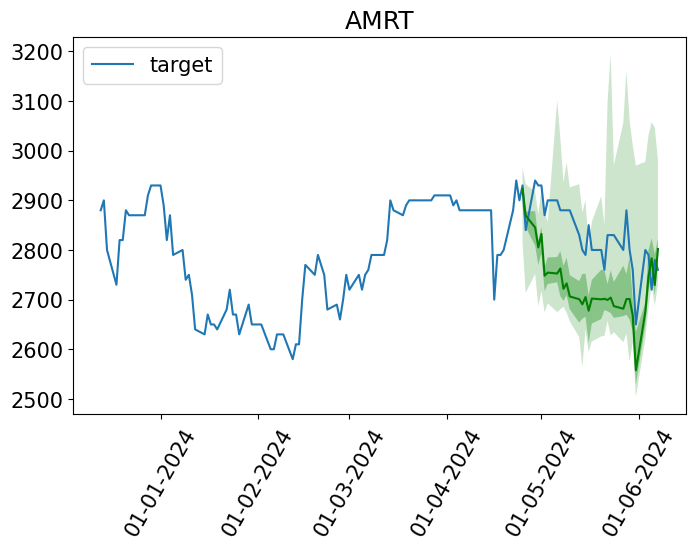

In [125]:
plotting(forecasts_fine_tuning_len_32_lr_5e_5, tss_fine_tuning_len_32_lr_5e_5)

### Get predictions with the default context length ***(64)***

In [126]:
forecasts_fine_tuning_len_64_lr_5e_5, tss_fine_tuning_len_64_lr_5e_5, agg_metrics = lag_llama_fine_tuning(64, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.09213 (best 5.09213), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_559\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.70719 (best 4.70719), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_559\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.67203 (best 4.67203), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_559\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 4.61267 (best 4.61267), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_559\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 4.60035 (best 4.60035), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [127]:
fine_tuning_len_64_lr_5e_5 = print_crps_fine_tuning(64, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 5e-05 CRPS: 0.0513


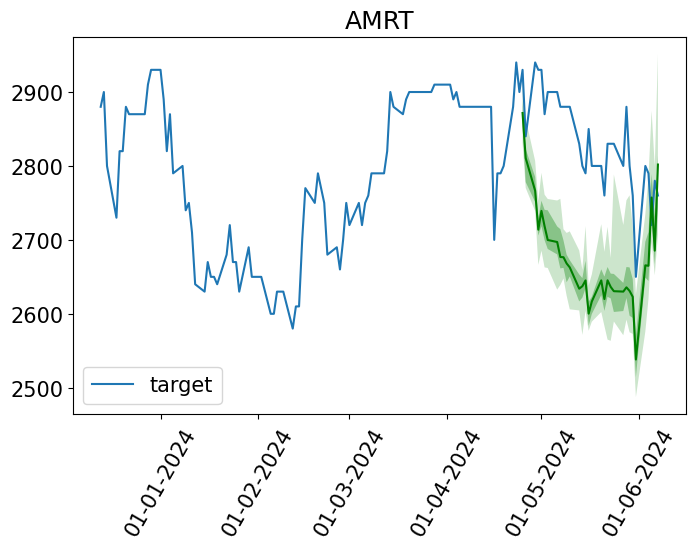

In [128]:
plotting(forecasts_fine_tuning_len_64_lr_5e_5, tss_fine_tuning_len_64_lr_5e_5)

### Get predictions with the default context length ***(128)***

In [129]:
forecasts_fine_tuning_len_128_lr_5e_5, tss_fine_tuning_len_128_lr_5e_5, agg_metrics = lag_llama_fine_tuning(128, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.01548 (best 5.01548), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_561\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.69510 (best 4.69510), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_561\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.61867 (best 4.61867), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_561\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.58992 (best 4.58992), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_561\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 4.55704 (best 4.55704), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [130]:
fine_tuning_len_128_lr_5e_5 = print_crps_fine_tuning(128, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 5e-05 CRPS: 0.0691


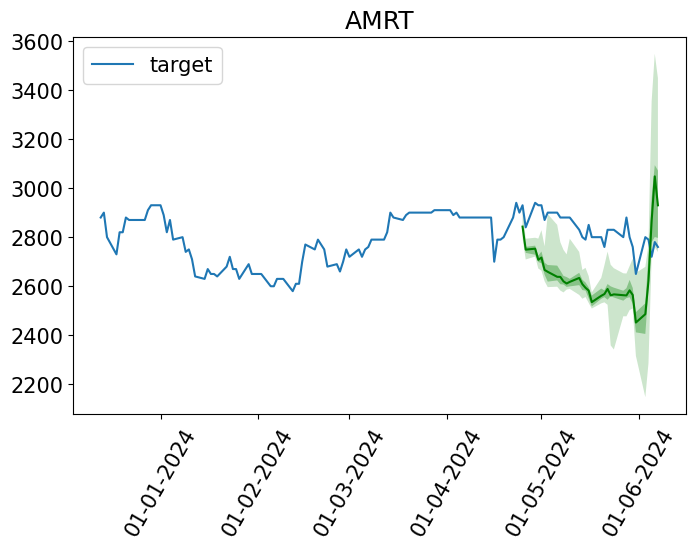

In [131]:
plotting(forecasts_fine_tuning_len_128_lr_5e_5, tss_fine_tuning_len_128_lr_5e_5)

### Get predictions with the default context length ***(256)***

In [132]:
forecasts_fine_tuning_len_256_lr_5e_5, tss_fine_tuning_len_256_lr_5e_5, agg_metrics = lag_llama_fine_tuning(256, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 4.90881 (best 4.90881), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_563\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.61833 (best 4.61833), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_563\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.57761 (best 4.57761), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_563\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.55399 (best 4.55399), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_563\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.51723 (best 4.51723), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_563\\checkpoints\\epoch=4-step=250.ckpt' as top

In [133]:
fine_tuning_len_256_lr_5e_5 = print_crps_fine_tuning(256, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 5e-05 CRPS: 0.0454


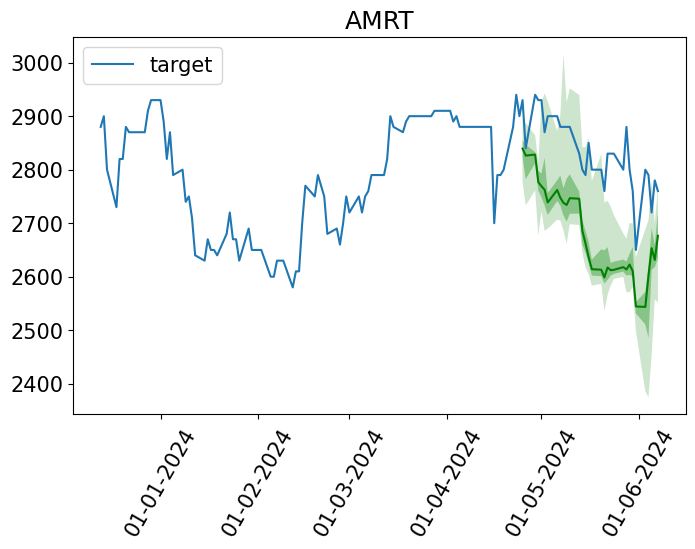

In [134]:
plotting(forecasts_fine_tuning_len_256_lr_5e_5, tss_fine_tuning_len_256_lr_5e_5)

### Get predictions with the default context length ***(512)***

In [135]:
forecasts_fine_tuning_len_512_lr_5e_5, tss_fine_tuning_len_512_lr_5e_5, agg_metrics = lag_llama_fine_tuning(512, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 4.82502 (best 4.82502), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_565\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.55686 (best 4.55686), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_565\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.47647 (best 4.47647), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_565\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.44591 (best 4.44591), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_565\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.42702 (best 4.42702), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_565\\checkpoints\\epoch=4-step=250.ckpt' as top

In [136]:
fine_tuning_len_512_lr_5e_5 = print_crps_fine_tuning(512, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 5e-05 CRPS: 0.0196


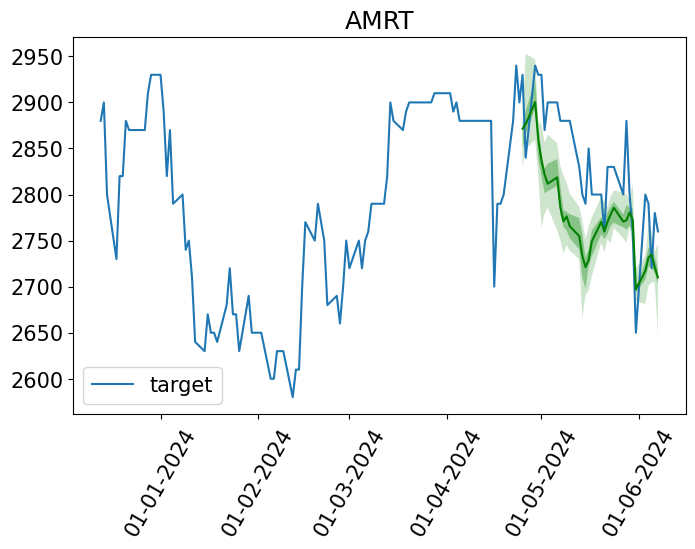

In [137]:
plotting(forecasts_fine_tuning_len_512_lr_5e_5, tss_fine_tuning_len_512_lr_5e_5)

### Get predictions with the default context length ***(1024)***

In [138]:
forecasts_fine_tuning_len_1024_lr_5e_5, tss_fine_tuning_len_1024_lr_5e_5, agg_metrics = lag_llama_fine_tuning(1024, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 4.89588 (best 4.89588), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_567\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.53970 (best 4.53970), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_567\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.47499 (best 4.47499), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_567\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.42693 (best 4.42693), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_567\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.41452 (best 4.41452), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_567\\checkpoints\\epoch=4-step=250.ckpt' as top

In [139]:
fine_tuning_len_1024_lr_5e_5 = print_crps_fine_tuning(1024, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 5e-05 CRPS: 0.0552


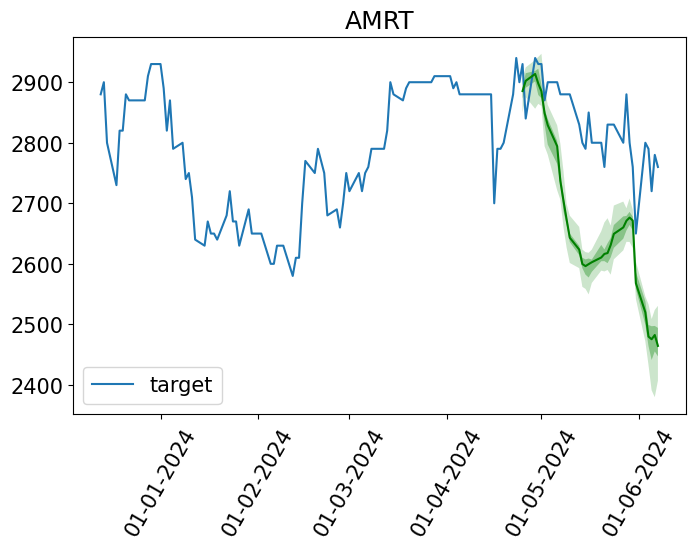

In [140]:
plotting(forecasts_fine_tuning_len_1024_lr_5e_5, tss_fine_tuning_len_1024_lr_5e_5)

# **Compared to TFT and DeepAR**

In [141]:
tft_estimator = TemporalFusionTransformerEstimator(
    prediction_length=prediction_length,
    context_length=32,
    freq="B",
    batch_size=batch_size,
    trainer_kwargs={"max_epochs": epoch}
)
deepar_estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=32,
    freq="B",
    batch_size=batch_size,
    trainer_kwargs={"max_epochs": epoch}
)

In [142]:
tft_predictor = tft_estimator.train(backtrain_dataset)
deepar_predictor = deepar_estimator.train(backtrain_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                           | Params | Mode  | In sizes                                                                           | Out sizes 
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
0 | model | TemporalFusionTransformerModel | 109 K  | train | [[1, 32], [1, 32], [1, 1], [1, 1], [1, 64, 3], [1, 64, 0], [1, 32, 0], [1, 32, 0]] | [1, 9, 32]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.439     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 877.13568 (best 877.13568), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_569\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 726.87634 (best 726.87634), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_569\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 697.60217 (best 697.60217), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_569\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 655.94385 (best 655.94385), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_569\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 626.09027 (best 626.09027), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_569\\checkpoints\\epoch=4-s

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.29142 (best 7.29142), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_571\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.13264 (best 6.13264), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_571\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.95208 (best 5.95208), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_571\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.83196 (best 5.83196), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_571\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.63753 (best 5.63753), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_571\\checkpoints\\epoch=4-step=250.ckpt' as top

In [143]:
tft_forecast_it, tft_ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=tft_predictor,
)

deepar_forecast_it, deepar_ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=deepar_predictor,
)

tft_forecasts = list(tft_forecast_it)
tft_tss = list(tft_ts_it)

deepar_forecasts = list(deepar_forecast_it)
deepar_tss = list(deepar_ts_it)

evaluator = Evaluator()
tft_agg_metrics, tft_ts_metrics = evaluator(iter(tft_tss), iter(tft_forecasts))
deepar_agg_metrics, deepar_ts_metrics = evaluator(iter(deepar_tss), iter(deepar_forecasts))

Running evaluation: 0it [00:00, ?it/s]The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
Running evaluation: 1it [00:00, 166.55it/s]
Running evaluation: 1it [00:00, 198.69it/s]


In [144]:
print(f"Temporal Fusion Transformer CRPS: {tft_agg_metrics['mean_wQuantileLoss']:.4f}")

Temporal Fusion Transformer CRPS: 0.0403


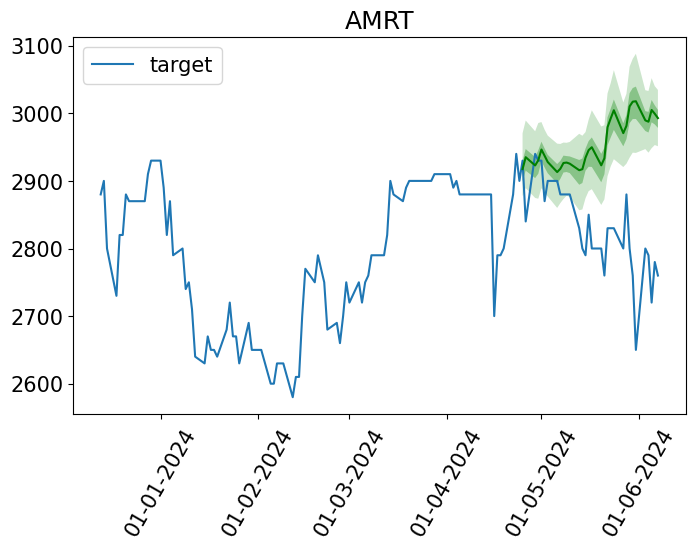

In [145]:
plotting(tft_forecasts, tft_tss)

In [146]:
print(f"DeepAR CRPS: {deepar_agg_metrics['mean_wQuantileLoss']:.4f}")

DeepAR CRPS: 0.0827


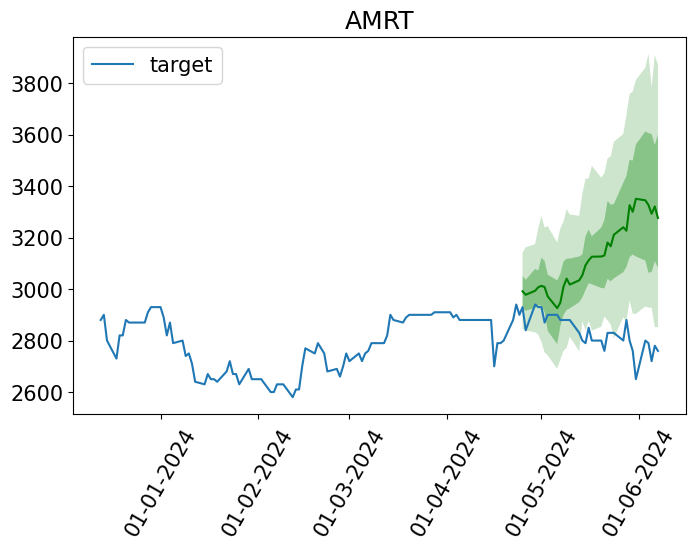

In [147]:
plotting(deepar_forecasts, deepar_tss)

# **Summary**

In [148]:
context_length = [32, 64, 128, 256, 512, 1024]
learning_rates = ['1e-2', '1e-3', '1e-4', '5e-3', '5e-4', '5e-5']

print("\n\033[1mLag-Llama Zero-Shot\033[0m")

# Lag-Llama Zero-Shot (False)
print("\n\033[1mRope scaled (False)\033[0m")
for length in context_length[:2]:
    print(f"Lag-Llama Zero-Shot ({length}) rope_scaled (False) CRPS: {globals()[f'zero_shot_len_{length}_false']:.4f}")

# Lag-Llama Zero-Shot (True)
print("\n\033[1mRope scaled (True)\033[0m")
for length in context_length[1:]:
    print(f"Lag-Llama Zero-Shot ({length}) rope_scaled (True) CRPS: {globals()[f'zero_shot_len_{length}_true']:.4f}")

# Lag-Llama Fine-Tuning
print("\n\033[1mLag-Llama Fine-Tuning\033[0m")
for lr in learning_rates:
    print(f"\n\033[1mLearning rate {lr}\033[0m")
    for length in context_length:
        variable_name = f"fine_tuning_len_{length}_lr_{lr.replace('-', '_')}"
        print(f"Lag-Llama Fine-Tuning ({length}) Lr {lr} CRPS: {globals()[variable_name]:.4f}")


print("\n\033[1mComparation Temporal Fusion Transformer (TFT) and DeepAR\033[0m")
print(f"Temporal Fusion Transformer CRPS: {tft_agg_metrics['mean_wQuantileLoss']:.4f}")
print(f"DeepAR CRPS: {deepar_agg_metrics['mean_wQuantileLoss']:.4f}")


Lag-Llama Zero-Shot

Rope scaled (False)
Lag-Llama Zero-Shot (32) rope_scaled (False) CRPS: 0.0383
Lag-Llama Zero-Shot (64) rope_scaled (False) CRPS: 0.0415

Rope scaled (True)
Lag-Llama Zero-Shot (64) rope_scaled (True) CRPS: 0.0422
Lag-Llama Zero-Shot (128) rope_scaled (True) CRPS: 0.0397
Lag-Llama Zero-Shot (256) rope_scaled (True) CRPS: 0.0394
Lag-Llama Zero-Shot (512) rope_scaled (True) CRPS: 0.0384
Lag-Llama Zero-Shot (1024) rope_scaled (True) CRPS: 0.0435

Lag-Llama Fine-Tuning

Learning rate 1e-2
Lag-Llama Fine-Tuning (32) Lr 1e-2 CRPS: 0.0498
Lag-Llama Fine-Tuning (64) Lr 1e-2 CRPS: 0.0295
Lag-Llama Fine-Tuning (128) Lr 1e-2 CRPS: 0.1072
Lag-Llama Fine-Tuning (256) Lr 1e-2 CRPS: 0.0491
Lag-Llama Fine-Tuning (512) Lr 1e-2 CRPS: 0.1349
Lag-Llama Fine-Tuning (1024) Lr 1e-2 CRPS: 0.0944

Learning rate 1e-3
Lag-Llama Fine-Tuning (32) Lr 1e-3 CRPS: 0.0984
Lag-Llama Fine-Tuning (64) Lr 1e-3 CRPS: 0.0349
Lag-Llama Fine-Tuning (128) Lr 1e-3 CRPS: 0.0538
Lag-Llama Fine-Tuning (256) Lr 

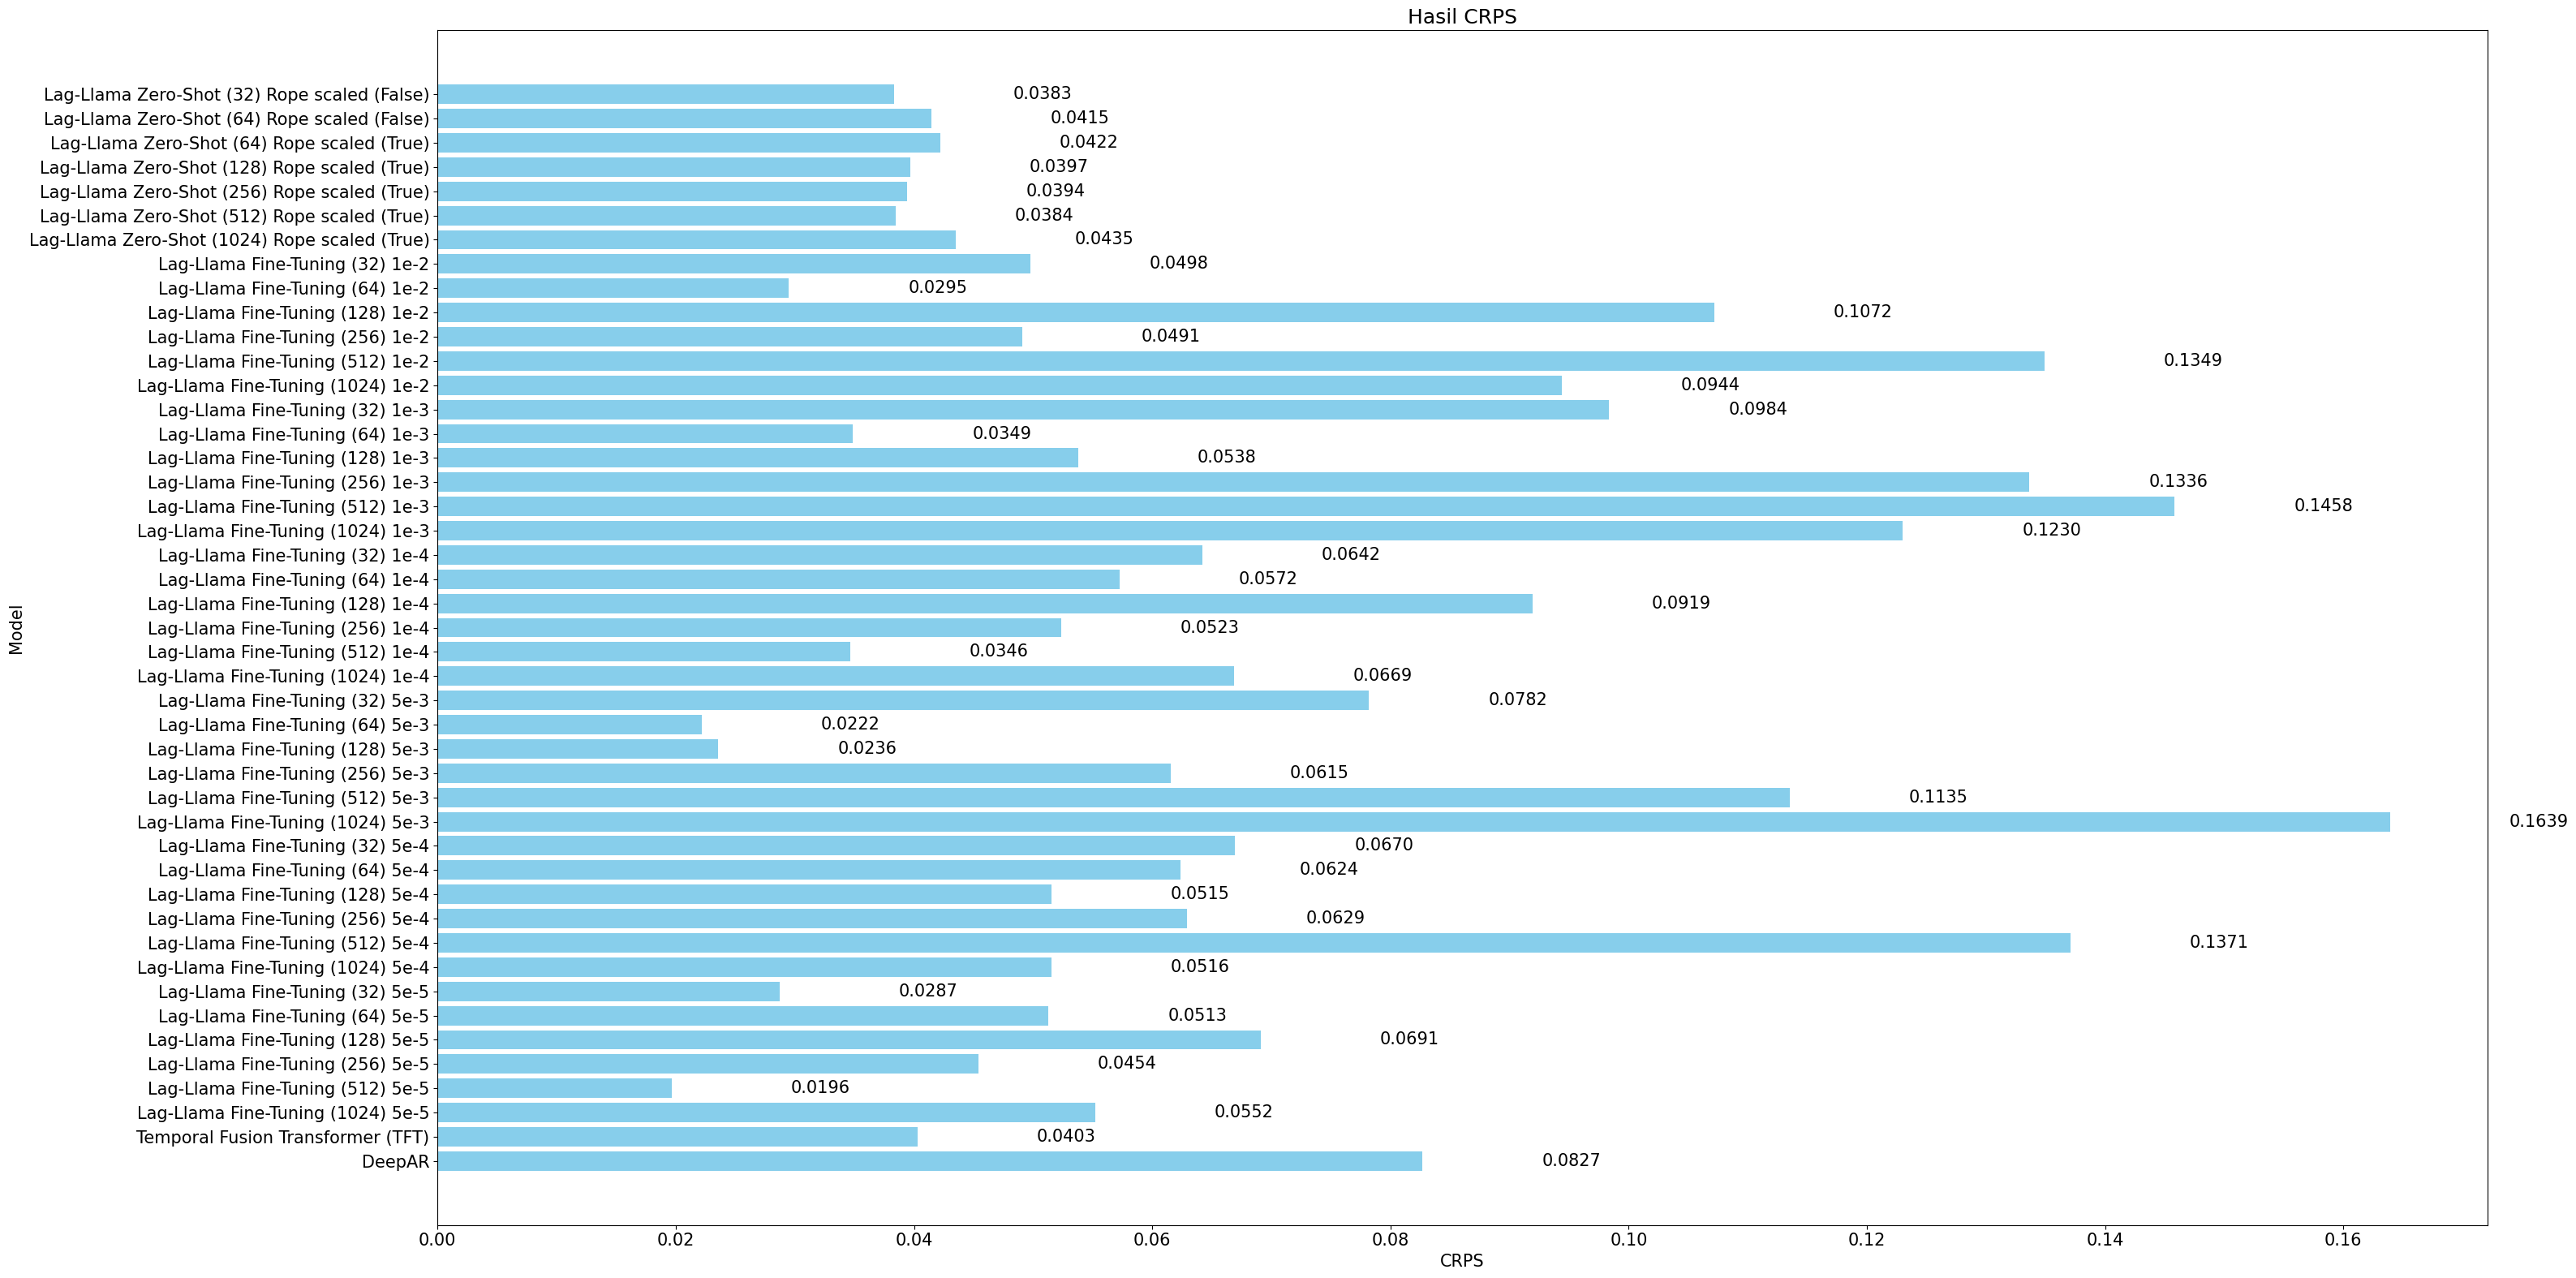

In [149]:
import matplotlib.pyplot as plt

def collect_crps_data(results):
    models, crps_values = [], []
    for model, data in results.items():
        if isinstance(data, dict):
            for sub_model, sub_data in data.items():
                for length, crps in sub_data.items():
                    models.append(f"{model} ({length}) {sub_model}")
                    crps_values.append(crps)
        else:
            models.append(model)
            crps_values.append(data)
    return models, crps_values

results = {
    "Lag-Llama Zero-Shot": {
        "Rope scaled (False)": {length: globals()[f'zero_shot_len_{length}_false'] for length in context_length[:2]},
        "Rope scaled (True)": {length: globals()[f'zero_shot_len_{length}_true'] for length in context_length[1:]}
    },
    "Lag-Llama Fine-Tuning": {
        lr: {length: globals()[f"fine_tuning_len_{length}_lr_{lr.replace('-', '_')}"] for length in context_length}
        for lr in learning_rates
    },
    "Temporal Fusion Transformer (TFT)": tft_agg_metrics['mean_wQuantileLoss'],
    "DeepAR": deepar_agg_metrics['mean_wQuantileLoss']
}

models, crps_values = collect_crps_data(results)
plt.figure(figsize=(32, 16))
bars = plt.barh(models, crps_values, color='skyblue')
plt.xlabel('CRPS')
plt.ylabel('Model')
plt.title('Hasil CRPS')
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{width:.4f}', va='center')

plt.tight_layout()
plt.show()

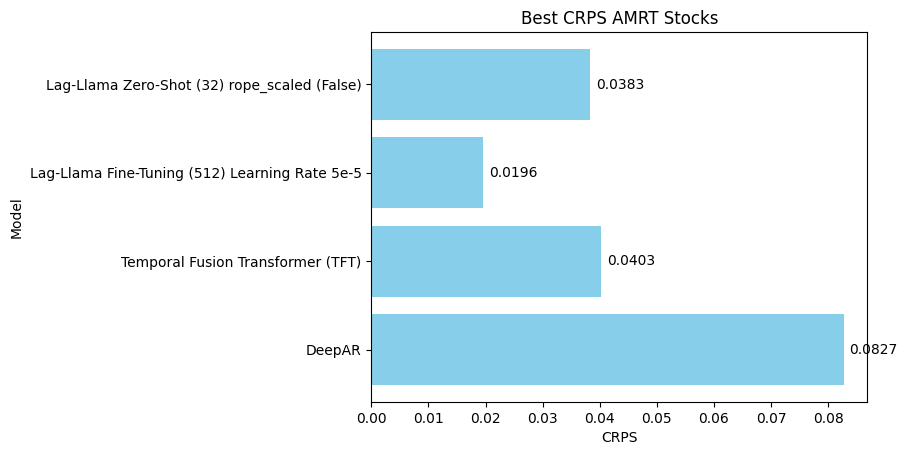

In [1]:
import matplotlib.pyplot as plt

data = {
    "Lag-Llama Zero-Shot (32) rope_scaled (False)": 0.0383,
    "Lag-Llama Fine-Tuning (512) Learning Rate 5e-5": 0.0196,
    "Temporal Fusion Transformer (TFT)": 0.0403,
    "DeepAR": 0.0827
}

models = list(data.keys())
crps_values = list(data.values())
fig, ax = plt.subplots()

bars = ax.barh(models, crps_values, color='skyblue')
plt.xlabel('CRPS')
plt.ylabel('Model')
plt.title('Best CRPS AMRT Stocks')
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height() / 2, f'{width:.4f}', va='center')

plt.show()